In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve,
    average_precision_score, roc_curve
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# MLflow imports
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
# import mlflow.catboost  # Uncomment if using CatBoost

# Global settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# MLflow Setup
# Set experiment name - all runs will be grouped under this experiment
EXPERIMENT_NAME = "defasagem_prediction"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {EXPERIMENT_NAME}")

2026/02/05 22:54:05 INFO mlflow.tracking.fluent: Experiment with name 'defasagem_prediction' does not exist. Creating a new experiment.


MLflow tracking URI: http://localhost:5000
Experiment: defasagem_prediction


In [4]:
df = pd.read_csv('../data/processed/students_feature_engineering.csv')
df.head()

,ipv,ips,iaa,ieg,nº_av,ida,defasagem,media
0,7.278,5.6,8.3,4.1,4.0,4.0,1,4.896857
1,6.778,6.3,8.8,5.2,4.0,6.8,0,5.411143
2,7.556,5.6,0.0,7.9,4.0,5.6,0,4.379429
3,5.278,5.6,8.8,4.5,4.0,5.0,0,4.739714
4,7.389,5.6,7.9,8.6,4.0,5.2,0,5.527000


In [5]:
# Separate features and target
# Features: ipv, ips, iaa, ieg, nº_av, ida, media
# Target: defasagem (0 or 1)
X = df[['ipv', 'ips', 'iaa', 'ieg', 'nº_av', 'ida', 'media']].copy()
y = df['defasagem'].copy()

# Check class balance
print("Target class distribution:")
print(y.value_counts(normalize=True))
print(f"\nTotal samples: {len(y)}")

Target class distribution:
defasagem
1    0.590158
0    0.409842
Name: proportion, dtype: float64

Total samples: 2845


In [6]:
# Stratified split: 70% train, 15% val, 15% test
# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE
)

# Second split: 70% train, 15% val (from the 85% remaining)
# 0.1765 * 0.85 ≈ 0.15
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
print(f"\nTrain distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nVal distribution:\n{y_val.value_counts(normalize=True)}")
print(f"\nTest distribution:\n{y_test.value_counts(normalize=True)}")

Train: 1991 | Val: 427 | Test: 427

Train distribution:
defasagem
1    0.590156
0    0.409844
Name: proportion, dtype: float64

Val distribution:
defasagem
1    0.590164
0    0.409836
Name: proportion, dtype: float64

Test distribution:
defasagem
1    0.590164
0    0.409836
Name: proportion, dtype: float64


In [7]:
# Log dataset split information to MLflow
# This creates a parent run for dataset information
with mlflow.start_run(run_name="dataset_info"):
    # Log split sizes
    mlflow.log_param("total_samples", len(df))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    mlflow.log_param("test_size", len(X_test))
    mlflow.log_param("train_ratio", len(X_train) / len(df))
    mlflow.log_param("val_ratio", len(X_val) / len(df))
    mlflow.log_param("test_ratio", len(X_test) / len(df))
    
    # Log feature names
    mlflow.log_param("features", ", ".join(X.columns.tolist()))
    mlflow.log_param("n_features", len(X.columns))
    mlflow.log_param("target", "defasagem")
    
    # Log class distribution
    mlflow.log_metric("class_0_total", int((y == 0).sum()))
    mlflow.log_metric("class_1_total", int((y == 1).sum()))
    mlflow.log_metric("class_imbalance_ratio", float((y == 0).sum() / (y == 1).sum()))
    
    # Log train distribution
    mlflow.log_metric("class_0_train", int((y_train == 0).sum()))
    mlflow.log_metric("class_1_train", int((y_train == 1).sum()))
    
    # Log val distribution
    mlflow.log_metric("class_0_val", int((y_val == 0).sum()))
    mlflow.log_metric("class_1_val", int((y_val == 1).sum()))
    
    # Log test distribution
    mlflow.log_metric("class_0_test", int((y_test == 0).sum()))
    mlflow.log_metric("class_1_test", int((y_test == 1).sum()))
    
    mlflow.log_param("random_state", RANDOM_STATE)

print("Dataset information logged to MLflow")

🏃 View run dataset_info at: http://localhost:5000/#/experiments/1/runs/c0f833e06bca4e06b8c87b66040e1326
🧪 View experiment at: http://localhost:5000/#/experiments/1
Dataset information logged to MLflow


In [8]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, log_to_mlflow=True):
    """
    Train model and evaluate on validation set
    Optionally logs to MLflow
    
    Args:
        model: sklearn-compatible model
        X_train, y_train: training data
        X_val, y_val: validation data
        model_name: string identifier for the model
        log_to_mlflow: whether to log results to MLflow
    
    Returns:
        metrics: dict with model performance metrics
        model: trained model object
    """
    
    # Start MLflow run if logging is enabled
    if log_to_mlflow:
        mlflow.start_run(run_name=model_name)
        
        # Log model parameters
        mlflow.log_params(model.get_params())
        
        # Log dataset information
        mlflow.log_param("train_samples", len(X_train))
        mlflow.log_param("val_samples", len(X_val))
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_param("class_0_train", int((y_train == 0).sum()))
        mlflow.log_param("class_1_train", int((y_train == 1).sum()))
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]  # Probability of class 1
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Recall': recall_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred),
        'ROC-AUC': roc_auc_score(y_val, y_proba),
        'PR-AUC': average_precision_score(y_val, y_proba)
    }
    
    # Log metrics to MLflow
    if log_to_mlflow:
        mlflow.log_metric("recall", metrics['Recall'])
        mlflow.log_metric("precision", metrics['Precision'])
        mlflow.log_metric("f1", metrics['F1'])
        mlflow.log_metric("roc_auc", metrics['ROC-AUC'])
        mlflow.log_metric("pr_auc", metrics['PR-AUC'])
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Log confusion matrix components
    if log_to_mlflow:
        tn, fp, fn, tp = cm.ravel()
        mlflow.log_metric("true_negatives", int(tn))
        mlflow.log_metric("false_positives", int(fp))
        mlflow.log_metric("false_negatives", int(fn))
        mlflow.log_metric("true_positives", int(tp))
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot 2: Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    axes[1].plot(recall, precision, marker='.')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'{model_name} - PR Curve (AUC={metrics["PR-AUC"]:.3f})')
    axes[1].grid(True)
    
    plt.tight_layout()
    
    # Save and log figure to MLflow
    if log_to_mlflow:
        fig_path = f"{model_name.replace(' ', '_')}_plots.png"
        plt.savefig(fig_path)
        mlflow.log_artifact(fig_path)
        plt.show()
        
        # Log model to MLflow
        # Automatically detects model type and logs appropriately
        if 'XGBoost' in model_name:
            mlflow.xgboost.log_model(model, "model")
        elif 'LightGBM' in model_name:
            mlflow.lightgbm.log_model(model, "model")
        # elif 'CatBoost' in model_name:
        #     mlflow.catboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")
        
        # End MLflow run
        mlflow.end_run()
    else:
        plt.show()
    
    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_val, y_pred))
    
    return metrics, model

In [9]:
def cross_val_metrics(model, X, y, cv=5, log_to_mlflow=False):
    """
    Perform stratified k-fold cross-validation
    Optionally logs CV metrics to current MLflow run
    
    Args:
        model: sklearn-compatible model
        X, y: training data
        cv: number of folds
        log_to_mlflow: whether to log to active MLflow run
    
    Returns:
        results: dict with mean ± std for each metric
    """
    
    # Stratified K-Fold to maintain class proportions
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Define scoring metrics
    scoring = {
        'recall': 'recall',
        'precision': 'precision',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    # Execute cross-validation
    cv_results = cross_validate(
        model, X, y, cv=skf, scoring=scoring, return_train_score=False
    )
    
    # Calculate mean and std
    recall_mean = cv_results['test_recall'].mean()
    recall_std = cv_results['test_recall'].std()
    precision_mean = cv_results['test_precision'].mean()
    precision_std = cv_results['test_precision'].std()
    f1_mean = cv_results['test_f1'].mean()
    f1_std = cv_results['test_f1'].std()
    roc_auc_mean = cv_results['test_roc_auc'].mean()
    roc_auc_std = cv_results['test_roc_auc'].std()
    
    # Log to MLflow if active run exists
    if log_to_mlflow and mlflow.active_run():
        mlflow.log_metric("cv_recall_mean", recall_mean)
        mlflow.log_metric("cv_recall_std", recall_std)
        mlflow.log_metric("cv_precision_mean", precision_mean)
        mlflow.log_metric("cv_precision_std", precision_std)
        mlflow.log_metric("cv_f1_mean", f1_mean)
        mlflow.log_metric("cv_f1_std", f1_std)
        mlflow.log_metric("cv_roc_auc_mean", roc_auc_mean)
        mlflow.log_metric("cv_roc_auc_std", roc_auc_std)
    
    # Format results as mean ± std
    results = {
        'CV Recall': f"{recall_mean:.3f} ± {recall_std:.3f}",
        'CV Precision': f"{precision_mean:.3f} ± {precision_std:.3f}",
        'CV F1': f"{f1_mean:.3f} ± {f1_std:.3f}",
        'CV ROC-AUC': f"{roc_auc_mean:.3f} ± {roc_auc_std:.3f}"
    }
    
    return results

BASELINE: DummyClassifier (Stratified)


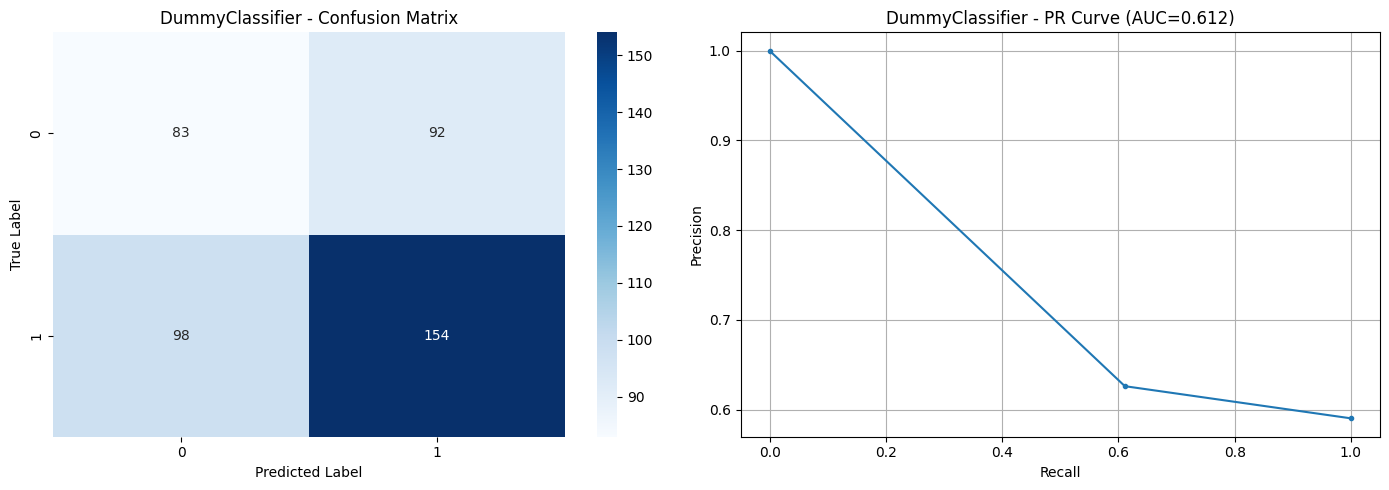

2026/02/05 22:55:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/1/runs/d3147e88c2be4407baf7a54325c5f0d2
🧪 View experiment at: http://localhost:5000/#/experiments/1

DummyClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.47       175
           1       0.63      0.61      0.62       252

    accuracy                           0.56       427
   macro avg       0.54      0.54      0.54       427
weighted avg       0.56      0.56      0.56       427


Cross-Validation Metrics:
CV Recall: 0.566 ± 0.019
CV Precision: 0.578 ± 0.020
CV F1: 0.572 ± 0.020
CV ROC-AUC: 0.486 ± 0.024


In [10]:
# Baseline 1: DummyClassifier (Stratified)
# This model randomly predicts classes according to training set distribution
# Serves as minimum performance threshold
print("="*60)
print("BASELINE: DummyClassifier (Stratified)")
print("="*60)

dummy = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

# Evaluate and log to MLflow
dummy_metrics, dummy_model = evaluate_model(
    dummy, X_train, y_train, X_val, y_val, 'DummyClassifier', log_to_mlflow=True
)

# Cross-validation (no need to log, already in main run)
dummy_cv = cross_val_metrics(dummy, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in dummy_cv.items():
    print(f"{k}: {v}")


ALGORITHM: Random Forest


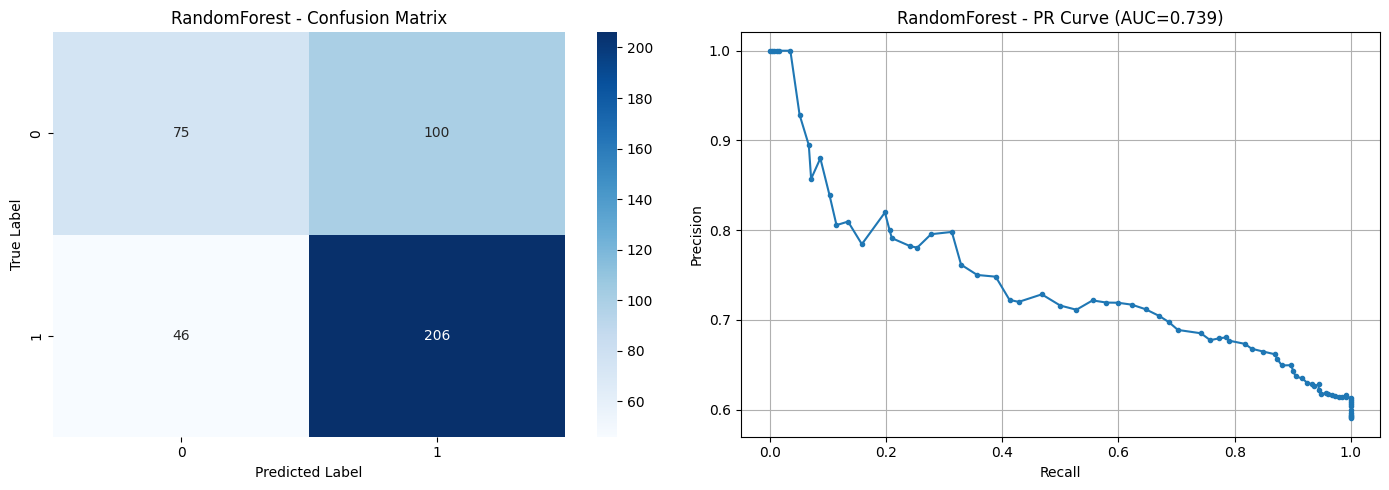

2026/02/05 22:55:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest at: http://localhost:5000/#/experiments/1/runs/52d25e751920440a84ddd1564c5e7354
🧪 View experiment at: http://localhost:5000/#/experiments/1

RandomForest - Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.43      0.51       175
           1       0.67      0.82      0.74       252

    accuracy                           0.66       427
   macro avg       0.65      0.62      0.62       427
weighted avg       0.65      0.66      0.64       427


Cross-Validation Metrics:
CV Recall: 0.820 ± 0.031
CV Precision: 0.683 ± 0.015
CV F1: 0.745 ± 0.016
CV ROC-AUC: 0.724 ± 0.011


In [11]:
# Random Forest with default hyperparameters
# Ensemble of decision trees with bootstrap sampling
print("\n" + "="*60)
print("ALGORITHM: Random Forest")
print("="*60)

rf = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    class_weight='balanced',   # Handle class imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1                  # Use all CPU cores
)

# Evaluate and log to MLflow
rf_metrics, rf_model = evaluate_model(
    rf, X_train, y_train, X_val, y_val, 'RandomForest', log_to_mlflow=True
)

# Cross-validation
rf_cv = cross_val_metrics(rf, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in rf_cv.items():
    print(f"{k}: {v}")


Feature Importance (Random Forest):
Feature  Importance
  media    0.208496
    ipv    0.190724
    ida    0.164855
    ieg    0.159058
    iaa    0.107848
    ips    0.105730
  nº_av    0.063289


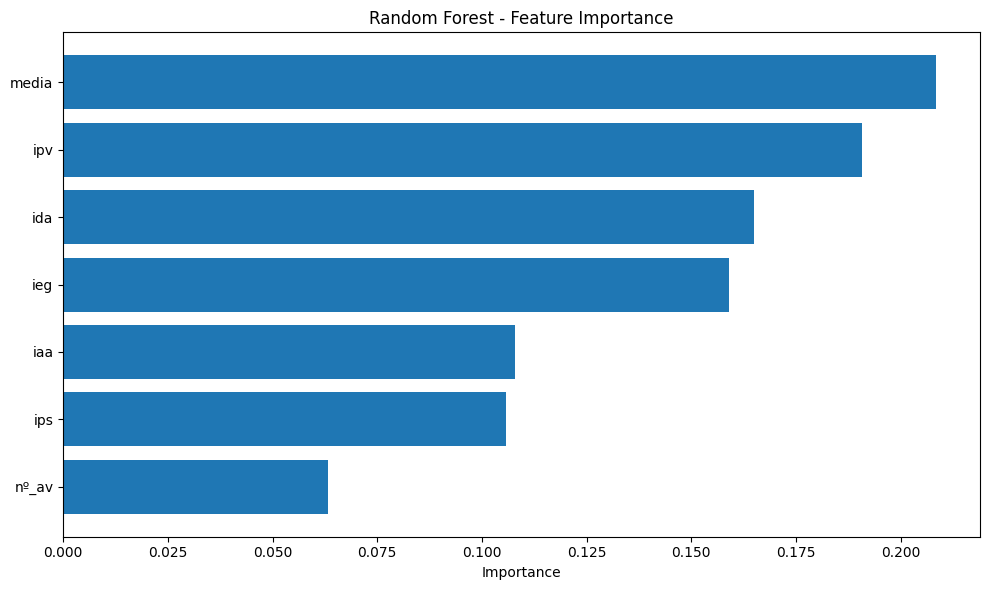

🏃 View run RandomForest_feature_importance at: http://localhost:5000/#/experiments/1/runs/53ce1113ae394a83ac6338b9ea039b9b
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [12]:
# Feature Importance Analysis for Random Forest
# Shows which features contribute most to predictions
with mlflow.start_run(run_name="RandomForest_feature_importance"):
    feature_importance_rf = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (Random Forest):")
    print(feature_importance_rf.to_string(index=False))
    
    # Log feature importances as metrics
    for idx, row in feature_importance_rf.iterrows():
        mlflow.log_metric(f"feat_imp_{row['Feature']}", row['Importance'])
    
    # Visualize and log
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'])
    plt.xlabel('Importance')
    plt.title('Random Forest - Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Save and log to MLflow
    fig_path = "rf_feature_importance.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()


ALGORITHM: XGBoost
Calculated scale_pos_weight: 0.69


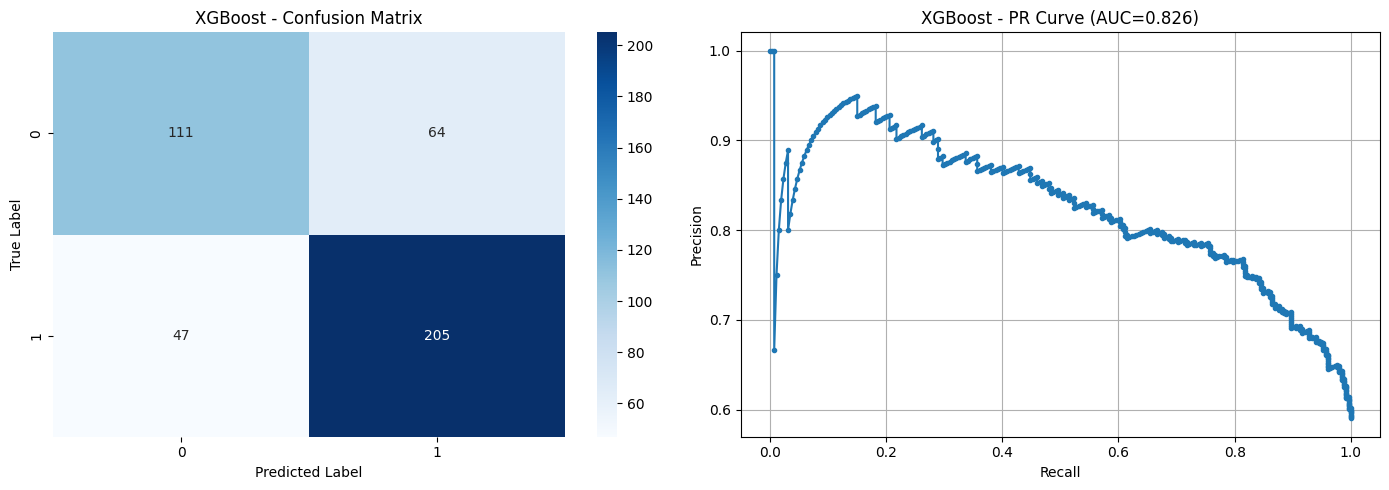

2026/02/05 22:56:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/1387e47260e94b9da08b13f642ff8ed8
🧪 View experiment at: http://localhost:5000/#/experiments/1

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.67       175
           1       0.76      0.81      0.79       252

    accuracy                           0.74       427
   macro avg       0.73      0.72      0.73       427
weighted avg       0.74      0.74      0.74       427


Cross-Validation Metrics:
CV Recall: 0.809 ± 0.022
CV Precision: 0.781 ± 0.024
CV F1: 0.794 ± 0.020
CV ROC-AUC: 0.825 ± 0.027


In [13]:
from xgboost import XGBClassifier

print("\n" + "="*60)
print("ALGORITHM: XGBoost")
print("="*60)

# Calculate scale_pos_weight for class imbalance
# Ratio of negative to positive samples
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

xgb = XGBClassifier(
    n_estimators=100,                  # Number of boosting rounds
    scale_pos_weight=scale_pos_weight, # Weight for positive class (handles imbalance)
    random_state=RANDOM_STATE,
    eval_metric='logloss',             # Evaluation metric during training
    use_label_encoder=False            # Avoid deprecation warning
)

# Evaluate and log to MLflow
xgb_metrics, xgb_model = evaluate_model(
    xgb, X_train, y_train, X_val, y_val, 'XGBoost', log_to_mlflow=True
)

# Cross-validation
xgb_cv = cross_val_metrics(xgb, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in xgb_cv.items():
    print(f"{k}: {v}")


Feature Importance (XGBoost):
Feature  Importance
  nº_av    0.201232
    ips    0.151386
  media    0.140110
    ipv    0.137194
    ida    0.128191
    ieg    0.127194
    iaa    0.114693


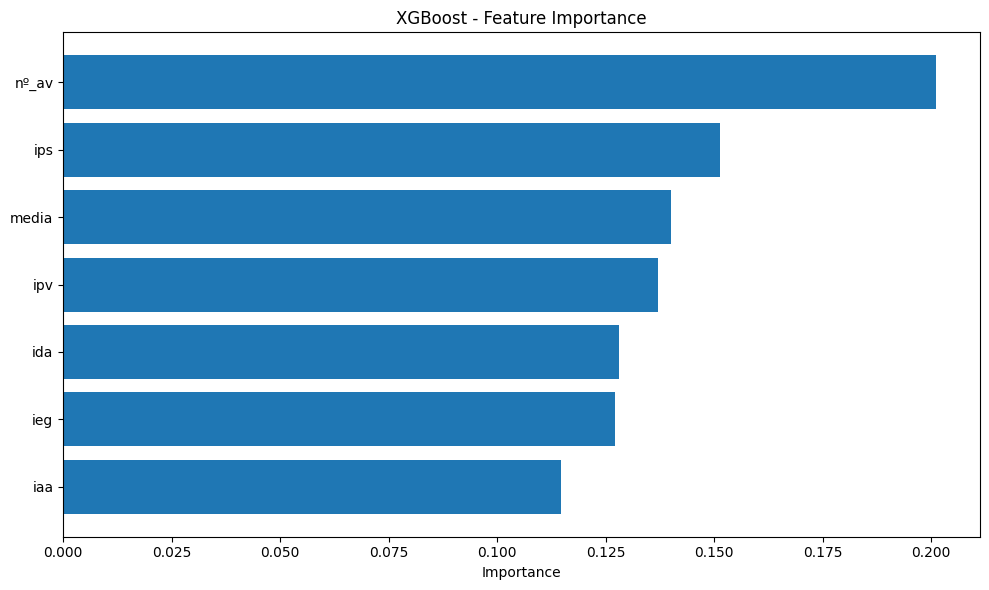

🏃 View run XGBoost_feature_importance at: http://localhost:5000/#/experiments/1/runs/86b173f75aa1418ea3852a7593bd044b
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [14]:
# Feature Importance Analysis for XGBoost
# Based on gain (average improvement in accuracy from splits using the feature)
with mlflow.start_run(run_name="XGBoost_feature_importance"):
    feature_importance_xgb = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (XGBoost):")
    print(feature_importance_xgb.to_string(index=False))
    
    # Log feature importances
    for idx, row in feature_importance_xgb.iterrows():
        mlflow.log_metric(f"feat_imp_{row['Feature']}", row['Importance'])
    
    # Visualize and log
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'])
    plt.xlabel('Importance')
    plt.title('XGBoost - Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    fig_path = "xgb_feature_importance.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()


ALGORITHM: LightGBM


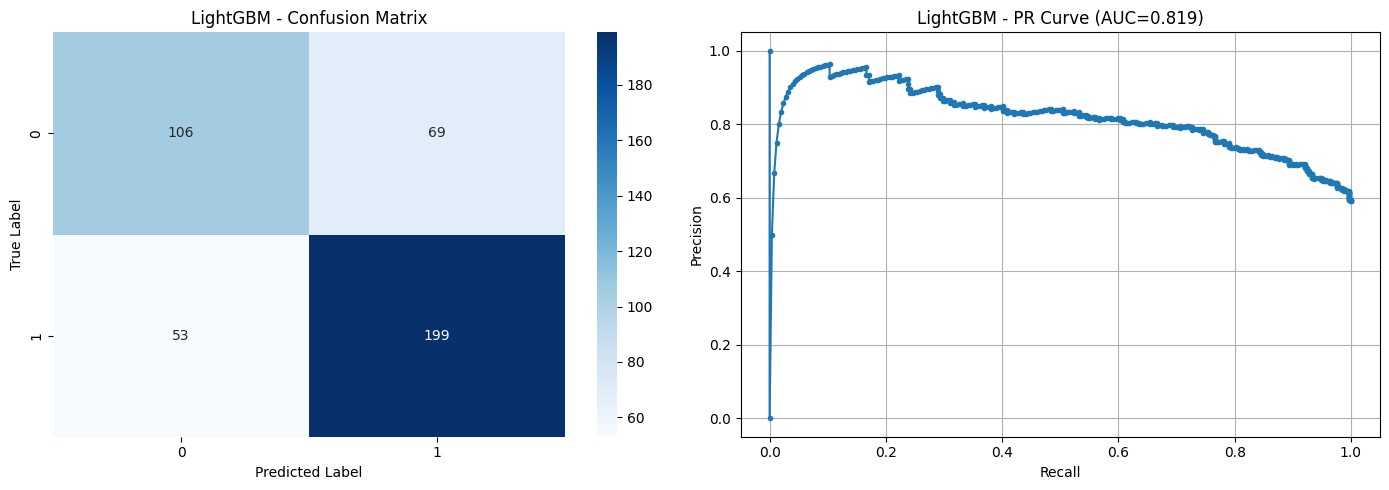

2026/02/05 22:56:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/1/runs/6c976393b99b48adb3e7ae1c3601fd16
🧪 View experiment at: http://localhost:5000/#/experiments/1

LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.63       175
           1       0.74      0.79      0.77       252

    accuracy                           0.71       427
   macro avg       0.70      0.70      0.70       427
weighted avg       0.71      0.71      0.71       427


Cross-Validation Metrics:
CV Recall: 0.776 ± 0.021
CV Precision: 0.771 ± 0.023
CV F1: 0.774 ± 0.019
CV ROC-AUC: 0.813 ± 0.020


In [15]:
from lightgbm import LGBMClassifier

print("\n" + "="*60)
print("ALGORITHM: LightGBM")
print("="*60)

lgbm = LGBMClassifier(
    n_estimators=100,          # Number of boosting iterations
    class_weight='balanced',   # Handle class imbalance
    random_state=RANDOM_STATE,
    verbose=-1                 # Suppress training output
)

# Evaluate and log to MLflow
lgbm_metrics, lgbm_model = evaluate_model(
    lgbm, X_train, y_train, X_val, y_val, 'LightGBM', log_to_mlflow=True
)

# Cross-validation
lgbm_cv = cross_val_metrics(lgbm, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in lgbm_cv.items():
    print(f"{k}: {v}")


Feature Importance (LightGBM):
Feature  Importance
  media         748
    ida         499
    ipv         482
    ieg         450
    ips         342
    iaa         300
  nº_av         179


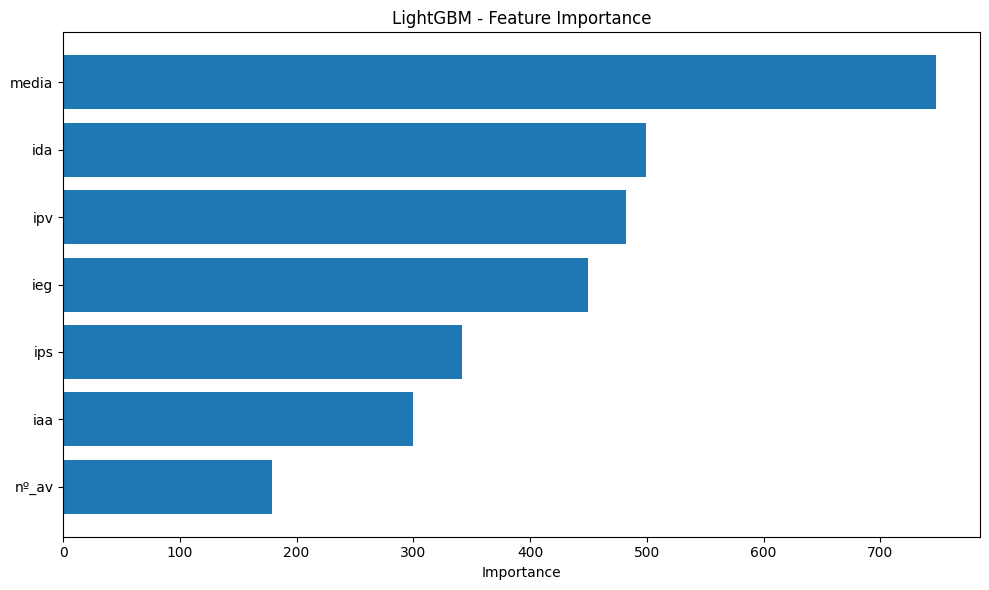

🏃 View run LightGBM_feature_importance at: http://localhost:5000/#/experiments/1/runs/73605f357bff4e6f98a7f128a67c34cc
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [16]:
# Feature Importance Analysis for LightGBM
# Based on split count (how many times feature is used to split data)
with mlflow.start_run(run_name="LightGBM_feature_importance"):
    feature_importance_lgbm = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': lgbm_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (LightGBM):")
    print(feature_importance_lgbm.to_string(index=False))
    
    # Log feature importances
    for idx, row in feature_importance_lgbm.iterrows():
        mlflow.log_metric(f"feat_imp_{row['Feature']}", row['Importance'])
    
    # Visualize and log
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_lgbm['Feature'], feature_importance_lgbm['Importance'])
    plt.xlabel('Importance')
    plt.title('LightGBM - Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    fig_path = "lgbm_feature_importance.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()

In [17]:
# Consolidate all results in a single dataframe
# Remove catboost_metrics from list if you didn't run CatBoost
all_results = pd.DataFrame([
    dummy_metrics,
    rf_metrics,
    xgb_metrics,
    lgbm_metrics,
])

print("\n" + "="*60)
print("FINAL COMPARISON - ALL MODELS")
print("="*60)
print(all_results.to_string(index=False))

# Identify best recall
best_recall_idx = all_results['Recall'].idxmax()
print(f"\nBest Recall: {all_results.loc[best_recall_idx, 'Model']} ({all_results.loc[best_recall_idx, 'Recall']:.3f})")

# Identify best PR-AUC (balanced metric for imbalanced data)
best_prauc_idx = all_results['PR-AUC'].idxmax()
print(f"Best PR-AUC: {all_results.loc[best_prauc_idx, 'Model']} ({all_results.loc[best_prauc_idx, 'PR-AUC']:.3f})")


FINAL COMPARISON - ALL MODELS
          Model   Recall  Precision       F1  ROC-AUC   PR-AUC
DummyClassifier 0.611111   0.626016 0.618474 0.542698 0.612074
   RandomForest 0.817460   0.673203 0.738351 0.678367 0.738965
        XGBoost 0.813492   0.762082 0.786948 0.789320 0.825912
       LightGBM 0.789683   0.742537 0.765385 0.778209 0.818560

Best Recall: RandomForest (0.817)
Best PR-AUC: XGBoost (0.826)


In [18]:
from sklearn.model_selection import GridSearchCV

print("\n" + "="*60)
print("HYPERPARAMETER TUNING: XGBoost (GridSearchCV)")
print("="*60)

# Start MLflow run for hyperparameter tuning
with mlflow.start_run(run_name="XGBoost_GridSearch"):
    
    # Define hyperparameter grid
    # Grid is intentionally small - expand based on computational resources
    param_grid_xgb = {
        'n_estimators': [100, 200, 300],           # Number of trees
        'max_depth': [3, 5, 7],                    # Maximum tree depth
        'learning_rate': [0.01, 0.05, 0.1],        # Step size shrinkage
        'subsample': [0.8, 1.0],                   # Fraction of samples for each tree
        'colsample_bytree': [0.8, 1.0],            # Fraction of features for each tree
        'min_child_weight': [1, 3, 5]              # Minimum sum of instance weight in a child
    }
    
    # Log search space
    mlflow.log_param("tuning_method", "GridSearchCV")
    mlflow.log_param("search_space_size", int(np.prod([len(v) for v in param_grid_xgb.values()])))
    mlflow.log_dict(param_grid_xgb, "param_grid.json")
    
    # Base estimator
    xgb_base = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # GridSearch with stratified cross-validation
    # WARNING: This can take a long time (hours) depending on grid size
    grid_search_xgb = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid_xgb,
        scoring='recall',  # Optimize for recall
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1,         # Use all CPU cores
        verbose=2          # Print progress
    )
    
    grid_search_xgb.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("best_cv_recall", grid_search_xgb.best_score_)
    
    # Log all CV results
    cv_results_df = pd.DataFrame(grid_search_xgb.cv_results_)
    cv_results_path = "grid_search_cv_results.csv"
    cv_results_df.to_csv(cv_results_path, index=False)
    mlflow.log_artifact(cv_results_path)
    
    print("\nBest hyperparameters (XGBoost):")
    print(grid_search_xgb.best_params_)
    print(f"\nBest CV Recall: {grid_search_xgb.best_score_:.3f}")


HYPERPARAMETER TUNING: XGBoost (GridSearchCV)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child

In [ ]:
# Evaluate best XGBoost model on validation set
# Create a new run for the tuned model evaluation
with mlflow.start_run(run_name="XGBoost_Tuned_Validation"):
    
    best_xgb = grid_search_xgb.best_estimator_
    
    # Log best parameters again for this run
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_param("tuned_with", "GridSearchCV")
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    
    y_pred_best = best_xgb.predict(X_val)
    y_proba_best = best_xgb.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    best_xgb_metrics = {
        'Model': 'XGBoost (Tuned)',
        'Recall': recall_score(y_val, y_pred_best),
        'Precision': precision_score(y_val, y_pred_best),
        'F1': f1_score(y_val, y_pred_best),
        'ROC-AUC': roc_auc_score(y_val, y_proba_best),
        'PR-AUC': average_precision_score(y_val, y_proba_best)
    }
    
    # Log metrics
    mlflow.log_metric("recall", best_xgb_metrics['Recall'])
    mlflow.log_metric("precision", best_xgb_metrics['Precision'])
    mlflow.log_metric("f1", best_xgb_metrics['F1'])
    mlflow.log_metric("roc_auc", best_xgb_metrics['ROC-AUC'])
    mlflow.log_metric("pr_auc", best_xgb_metrics['PR-AUC'])
    
    # Confusion matrix
    cm_best = confusion_matrix(y_val, y_pred_best)
    tn, fp, fn, tp = cm_best.ravel()
    mlflow.log_metric("true_negatives", int(tn))
    mlflow.log_metric("false_positives", int(fp))
    mlflow.log_metric("false_negatives", int(fn))
    mlflow.log_metric("true_positives", int(tp))
    
    # Log model
    mlflow.xgboost.log_model(best_xgb, "model")
    
    print("\n" + "="*60)
    print("XGBOOST TUNED - VALIDATION METRICS")
    print("="*60)
    for k, v in best_xgb_metrics.items():
        print(f"{k}: {v}")
    
    print("\nConfusion Matrix:")
    print(cm_best)
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_best))

2026/02/05 22:57:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



XGBOOST TUNED - VALIDATION METRICS
Model: XGBoost (Tuned)
Recall: 0.8253968253968254
Precision: 0.7969348659003831
F1: 0.8109161793372319
ROC-AUC: 0.8441043083900226
PR-AUC: 0.8679520122087281

Confusion Matrix:
[[122  53]
 [ 44 208]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       175
           1       0.80      0.83      0.81       252

    accuracy                           0.77       427
   macro avg       0.77      0.76      0.76       427
weighted avg       0.77      0.77      0.77       427

🏃 View run XGBoost_Tuned_Validation at: http://localhost:5000/#/experiments/1/runs/01a3b2edc4bc4a1badce025f6a3a7250
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [21]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration.mlflow import MLflowCallback
import mlflow
import pandas as pd
import matplotlib.pyplot as plt  # caso precise gerar gráficos adicionais

# =============================================================================
# HYPERPARAMETER TUNING: XGBoost (Optuna + MLflow)
# =============================================================================
print("\n" + "="*60)
print("HYPERPARAMETER TUNING: XGBoost (Optuna)")
print("="*60)

# Configuração do callback MLflow
# O parâmetro nested=True é essencial para evitar conflito de runs ativos
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name="cv_recall",
    mlflow_kwargs={
        "nested": True,               # ← Solução principal para o erro
        "run_name_prefix": "trial_"   # Opcional: facilita identificar os trials
    }
)

def objective(trial):
    """
    Função objetivo para otimização com Optuna.
    Objetivo: Maximizar o recall médio na validação cruzada.
    
    Args:
        trial: Objeto Trial do Optuna para sugerir hiperparâmetros
    
    Returns:
        float: Média do recall nas folds de validação cruzada
    """
    # Sugestão inteligente dos hiperparâmetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'scale_pos_weight': scale_pos_weight,      # deve estar definido antes
        'random_state': RANDOM_STATE,              # deve estar definido antes
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_jobs': -1,                              # boa prática
        'verbosity': 0                             # evita poluição no console
    }

    # Instancia o modelo com os parâmetros sugeridos
    model = XGBClassifier(**params)

    # Validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    cv_scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring='recall',
        n_jobs=-1,                  # paraleliza as folds
        return_train_score=False
    )

    # Retorna a média do recall
    mean_recall = cv_scores['test_score'].mean()
    
    # Opcional: registrar o valor intermediário para o Optuna acompanhar
    trial.set_user_attr("cv_recall_std", cv_scores['test_score'].std())
    
    return mean_recall


# =============================================================================
# Criação e execução do estudo
# =============================================================================

# Criação do estudo
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name="xgboost_optuna_tuning",
    storage="sqlite:///optuna_xgboost_study.db",   # opcional: persiste o estudo
    load_if_exists=True                            # continua se já existir
)

# Executa a otimização (sem precisar de mlflow.start_run manual aqui)
study.optimize(
    objective,
    n_trials=100,
    callbacks=[mlflow_callback],
    show_progress_bar=True
)


# =============================================================================
# Registro dos resultados finais (fora do callback)
# =============================================================================

# Inicia um run pai apenas para registrar os resultados finais e artefatos
with mlflow.start_run(run_name="XGBoost_Optuna_Study_Final", nested=True):
    
    # Log dos parâmetros do estudo
    mlflow.log_param("tuning_method", "Optuna")
    mlflow.log_param("n_trials", 100)
    mlflow.log_param("sampler", "TPE")
    mlflow.log_param("n_trials_completed", len(study.trials))
    
    # Log dos melhores hiperparâmetros e métrica
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_cv_recall", study.best_value)
    
    # Salva e registra o histórico completo
    trials_df = study.trials_dataframe()
    history_path = "optuna_trials_history.csv"
    trials_df.to_csv(history_path, index=False)
    mlflow.log_artifact(history_path)
    
    # Gráficos do Optuna (visualizações interativas)
    try:
        fig_history = optuna.visualization.plot_optimization_history(study)
        fig_history.write_html("optuna_optimization_history.html")
        mlflow.log_artifact("optuna_optimization_history.html")
        
        fig_importance = optuna.visualization.plot_param_importances(study)
        fig_importance.write_html("optuna_param_importance.html")
        mlflow.log_artifact("optuna_param_importance.html")
    except Exception as e:
        print(f"Erro ao gerar gráficos do Optuna: {e}")
    
    print("\n" + "="*60)
    print("MELHOR RESULTADO ENCONTRADO")
    print("="*60)
    print("Melhores hiperparâmetros:")
    print(study.best_params)
    print(f"\nMelhor Recall médio (CV): {study.best_value:.4f}")
    print(f"Número de trials concluídos: {len(study.trials)}")


HYPERPARAMETER TUNING: XGBoost (Optuna)


[I 2026-02-05 23:05:49,779] A new study created in RDB with name: xgboost_optuna_tuning
  0%|          | 0/100 [00:01<?, ?it/s]

[I 2026-02-05 23:05:51,709] Trial 0 finished with value: 0.7829787234042553 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.7829787234042553.


Best trial: 0. Best value: 0.782979:   1%|          | 1/100 [00:02<03:45,  2.28s/it]

🏃 View run 0 at: http://localhost:5000/#/experiments/2/runs/2da74b5499c947b585985ebd997fd9d6
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 0. Best value: 0.782979:   1%|          | 1/100 [00:03<03:45,  2.28s/it]

[I 2026-02-05 23:05:53,715] Trial 1 finished with value: 0.8493617021276595 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   2%|▏         | 2/100 [00:04<03:26,  2.10s/it]

🏃 View run 1 at: http://localhost:5000/#/experiments/2/runs/931859f5e9cc4d558cdf73fd7bf6e669
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   2%|▏         | 2/100 [00:05<03:26,  2.10s/it]

[I 2026-02-05 23:05:55,370] Trial 2 finished with value: 0.7965957446808509 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'min_child_weight': 4, 'gamma': 0.22803499210851796, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   3%|▎         | 3/100 [00:05<03:05,  1.91s/it]

🏃 View run 2 at: http://localhost:5000/#/experiments/2/runs/d3820c51bf1b4ea89c2ad98cdcd2ff71
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   3%|▎         | 3/100 [00:06<03:05,  1.91s/it]

[I 2026-02-05 23:05:55,986] Trial 3 finished with value: 0.7055319148936171 and parameters: {'n_estimators': 306, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'min_child_weight': 1, 'gamma': 0.4744427686266666, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   4%|▍         | 4/100 [00:06<02:13,  1.39s/it]

🏃 View run 3 at: http://localhost:5000/#/experiments/2/runs/84d45ef00b234e03bd9f1a2bfda3180c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   4%|▍         | 4/100 [00:06<02:13,  1.39s/it]

[I 2026-02-05 23:05:56,464] Trial 4 finished with value: 0.7531914893617021 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'min_child_weight': 5, 'gamma': 0.017194260557609198, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   5%|▌         | 5/100 [00:07<01:42,  1.07s/it]

🏃 View run 4 at: http://localhost:5000/#/experiments/2/runs/9320eca8f99f4319b670fdc7400240e9
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   5%|▌         | 5/100 [00:07<01:42,  1.07s/it]

[I 2026-02-05 23:05:57,043] Trial 5 finished with value: 0.7506382978723403 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'min_child_weight': 10, 'gamma': 0.3875664116805573, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   6%|▌         | 6/100 [00:07<01:24,  1.11it/s]

🏃 View run 5 at: http://localhost:5000/#/experiments/2/runs/a6295f83df874e8bb7d33e28b403a877
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   6%|▌         | 6/100 [00:07<01:24,  1.11it/s]

[I 2026-02-05 23:05:57,666] Trial 6 finished with value: 0.7004255319148935 and parameters: {'n_estimators': 339, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'min_child_weight': 4, 'gamma': 0.194338644844741, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   7%|▋         | 7/100 [00:08<01:15,  1.24it/s]

🏃 View run 6 at: http://localhost:5000/#/experiments/2/runs/5bdb0a40cfe54058b0d7bbd625b67de6
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   7%|▋         | 7/100 [00:08<01:15,  1.24it/s]

[I 2026-02-05 23:05:58,232] Trial 7 finished with value: 0.7931914893617021 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'min_child_weight': 1, 'gamma': 0.49344346830025865, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   8%|▊         | 8/100 [00:08<01:08,  1.35it/s]

🏃 View run 7 at: http://localhost:5000/#/experiments/2/runs/6073239723c04d07b878532c51bf245d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   8%|▊         | 8/100 [00:09<01:08,  1.35it/s]

[I 2026-02-05 23:05:58,841] Trial 8 finished with value: 0.7855319148936171 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'min_child_weight': 1, 'gamma': 0.1792328642721363, 'reg_alpha': 0.11586905952512971, 'reg_lambda': 0.8631034258755935}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:   9%|▉         | 9/100 [00:09<01:02,  1.46it/s]

🏃 View run 8 at: http://localhost:5000/#/experiments/2/runs/07f92fb57fda48ef84343ecc80293469
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:   9%|▉         | 9/100 [00:09<01:02,  1.46it/s]

[I 2026-02-05 23:05:59,394] Trial 9 finished with value: 0.7038297872340425 and parameters: {'n_estimators': 349, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_weight': 8, 'gamma': 0.31877873567760656, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}. Best is trial 1 with value: 0.8493617021276595.


Best trial: 1. Best value: 0.849362:  10%|█         | 10/100 [00:09<00:57,  1.58it/s]

🏃 View run 9 at: http://localhost:5000/#/experiments/2/runs/ae145dc6fd3d437087f43ab074e9dd55
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 1. Best value: 0.849362:  10%|█         | 10/100 [00:10<00:57,  1.58it/s]

[I 2026-02-05 23:05:59,895] Trial 10 finished with value: 0.865531914893617 and parameters: {'n_estimators': 488, 'max_depth': 3, 'learning_rate': 0.27047297227177763, 'subsample': 0.9810323243403002, 'colsample_bytree': 0.8182873120328862, 'min_child_weight': 7, 'gamma': 0.1277217293825994, 'reg_alpha': 0.4040260720186447, 'reg_lambda': 0.4792951727359478}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  11%|█         | 11/100 [00:10<00:54,  1.63it/s]

🏃 View run 10 at: http://localhost:5000/#/experiments/2/runs/c146fe0aa76d43ba99ff4d55067543ab
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  11%|█         | 11/100 [00:10<00:54,  1.63it/s]

[I 2026-02-05 23:06:00,486] Trial 11 finished with value: 0.861276595744681 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.24950292438859484, 'subsample': 0.9884860601009259, 'colsample_bytree': 0.8153994220705195, 'min_child_weight': 7, 'gamma': 0.09996988961166513, 'reg_alpha': 0.4635918553211216, 'reg_lambda': 0.48341897064943684}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  12%|█▏        | 12/100 [00:11<00:53,  1.64it/s]

🏃 View run 11 at: http://localhost:5000/#/experiments/2/runs/49cb83dcf2fa45869accd9fbc6cf21ea
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  12%|█▏        | 12/100 [00:11<00:53,  1.64it/s]

[I 2026-02-05 23:06:01,023] Trial 12 finished with value: 0.8519148936170213 and parameters: {'n_estimators': 487, 'max_depth': 3, 'learning_rate': 0.28298068968665446, 'subsample': 0.9995060732338602, 'colsample_bytree': 0.8187954328668745, 'min_child_weight': 7, 'gamma': 0.1106715492431963, 'reg_alpha': 0.5615195711001008, 'reg_lambda': 0.3945277342875057}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  13%|█▎        | 13/100 [00:11<00:50,  1.73it/s]

🏃 View run 12 at: http://localhost:5000/#/experiments/2/runs/af9f620ba5864f929d047fbff2b402c7
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  13%|█▎        | 13/100 [00:11<00:50,  1.73it/s]

[I 2026-02-05 23:06:01,622] Trial 13 finished with value: 0.8272340425531916 and parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.16404322580340455, 'subsample': 0.9997449754566206, 'colsample_bytree': 0.822641447221497, 'min_child_weight': 7, 'gamma': 0.12091701567204471, 'reg_alpha': 0.5293469466158548, 'reg_lambda': 0.6693201910118401}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  14%|█▍        | 14/100 [00:12<00:50,  1.71it/s]

🏃 View run 13 at: http://localhost:5000/#/experiments/2/runs/5879a2bceb6c432581fad91e114e9e7e
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  14%|█▍        | 14/100 [00:12<00:50,  1.71it/s]

[I 2026-02-05 23:06:02,222] Trial 14 finished with value: 0.7608510638297872 and parameters: {'n_estimators': 430, 'max_depth': 4, 'learning_rate': 0.03714200138875004, 'subsample': 0.9367745100544795, 'colsample_bytree': 0.9978752684152137, 'min_child_weight': 9, 'gamma': 0.27939929152165716, 'reg_alpha': 0.3849679031223864, 'reg_lambda': 0.3846362884431037}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  15%|█▌        | 15/100 [00:12<00:50,  1.68it/s]

🏃 View run 14 at: http://localhost:5000/#/experiments/2/runs/cadfa57a8b3e402dae5c034a99cbd31c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  15%|█▌        | 15/100 [00:13<00:50,  1.68it/s]

[I 2026-02-05 23:06:02,801] Trial 15 finished with value: 0.734468085106383 and parameters: {'n_estimators': 438, 'max_depth': 4, 'learning_rate': 0.026624223212611594, 'subsample': 0.9404553650035126, 'colsample_bytree': 0.7708806511395082, 'min_child_weight': 6, 'gamma': 0.15472815134617385, 'reg_alpha': 0.6412492882382235, 'reg_lambda': 0.6847322143200381}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  16%|█▌        | 16/100 [00:13<00:49,  1.70it/s]

🏃 View run 15 at: http://localhost:5000/#/experiments/2/runs/5bf40c014b394df6a499804979b65851
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  16%|█▌        | 16/100 [00:13<00:49,  1.70it/s]

[I 2026-02-05 23:06:03,454] Trial 16 finished with value: 0.8544680851063831 and parameters: {'n_estimators': 429, 'max_depth': 8, 'learning_rate': 0.19408516667353218, 'subsample': 0.8836077324310705, 'colsample_bytree': 0.8700292561874855, 'min_child_weight': 8, 'gamma': 0.06464929223279153, 'reg_alpha': 0.02721902639119672, 'reg_lambda': 0.013179214380923454}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  17%|█▋        | 17/100 [00:14<00:50,  1.64it/s]

🏃 View run 16 at: http://localhost:5000/#/experiments/2/runs/0432fe347b5444f4a434ce41dc660b7c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  17%|█▋        | 17/100 [00:14<00:50,  1.64it/s]

[I 2026-02-05 23:06:04,005] Trial 17 finished with value: 0.8025531914893618 and parameters: {'n_estimators': 185, 'max_depth': 6, 'learning_rate': 0.16299485419239088, 'subsample': 0.9663618049470519, 'colsample_bytree': 0.7732285223717067, 'min_child_weight': 6, 'gamma': 0.2533881284358335, 'reg_alpha': 0.4519696249497039, 'reg_lambda': 0.3074325501369379}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  18%|█▊        | 18/100 [00:14<00:47,  1.71it/s]

🏃 View run 17 at: http://localhost:5000/#/experiments/2/runs/3a83cddd5dc041bea03c127440c2e447
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  18%|█▊        | 18/100 [00:14<00:47,  1.71it/s]

[I 2026-02-05 23:06:04,642] Trial 18 finished with value: 0.8382978723404255 and parameters: {'n_estimators': 472, 'max_depth': 4, 'learning_rate': 0.21623470239935283, 'subsample': 0.601411953133355, 'colsample_bytree': 0.8567696352548534, 'min_child_weight': 10, 'gamma': 0.003630416715954196, 'reg_alpha': 0.1988601536779836, 'reg_lambda': 0.5198983996216158}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  19%|█▉        | 19/100 [00:15<00:48,  1.67it/s]

🏃 View run 18 at: http://localhost:5000/#/experiments/2/runs/f09dff2be8a34f598277436f728873e9
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  19%|█▉        | 19/100 [00:15<00:48,  1.67it/s]

[I 2026-02-05 23:06:05,243] Trial 19 finished with value: 0.7838297872340425 and parameters: {'n_estimators': 405, 'max_depth': 6, 'learning_rate': 0.03910891361220486, 'subsample': 0.8851188301403033, 'colsample_bytree': 0.9548564398401693, 'min_child_weight': 8, 'gamma': 0.15599990586427023, 'reg_alpha': 0.6427654544859114, 'reg_lambda': 0.04335709592335846}. Best is trial 10 with value: 0.865531914893617.


Best trial: 10. Best value: 0.865532:  20%|██        | 20/100 [00:15<00:47,  1.67it/s]

🏃 View run 19 at: http://localhost:5000/#/experiments/2/runs/c9eee0337b56448290bc42f2d6ad82d2
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 10. Best value: 0.865532:  20%|██        | 20/100 [00:15<00:47,  1.67it/s]

[I 2026-02-05 23:06:05,780] Trial 20 finished with value: 0.8791489361702128 and parameters: {'n_estimators': 451, 'max_depth': 3, 'learning_rate': 0.2961731536915935, 'subsample': 0.7662237798289577, 'colsample_bytree': 0.8595970772247415, 'min_child_weight': 5, 'gamma': 0.0693849697152994, 'reg_alpha': 0.40424367053218124, 'reg_lambda': 0.9938427850497087}. Best is trial 20 with value: 0.8791489361702128.


Best trial: 20. Best value: 0.879149:  21%|██        | 21/100 [00:16<00:46,  1.71it/s]

🏃 View run 20 at: http://localhost:5000/#/experiments/2/runs/7d95d5c025a34615b6f00b27135823e0
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 20. Best value: 0.879149:  21%|██        | 21/100 [00:16<00:46,  1.71it/s]

[I 2026-02-05 23:06:06,335] Trial 21 finished with value: 0.8834042553191489 and parameters: {'n_estimators': 453, 'max_depth': 3, 'learning_rate': 0.25342484757924216, 'subsample': 0.7707061221366315, 'colsample_bytree': 0.8623659733565988, 'min_child_weight': 5, 'gamma': 0.06425076482832652, 'reg_alpha': 0.4002933655794753, 'reg_lambda': 0.7090197191657357}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  22%|██▏       | 22/100 [00:16<00:44,  1.75it/s]

🏃 View run 21 at: http://localhost:5000/#/experiments/2/runs/fae04c565e6347f09f9baef4813dbcb3
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  22%|██▏       | 22/100 [00:17<00:44,  1.75it/s]

[I 2026-02-05 23:06:06,878] Trial 22 finished with value: 0.8697872340425532 and parameters: {'n_estimators': 445, 'max_depth': 4, 'learning_rate': 0.29965011122125396, 'subsample': 0.7690298678707416, 'colsample_bytree': 0.863145635368178, 'min_child_weight': 4, 'gamma': 0.051987654996403135, 'reg_alpha': 0.35223655075162075, 'reg_lambda': 0.9703798049018051}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  23%|██▎       | 23/100 [00:17<00:43,  1.79it/s]

🏃 View run 22 at: http://localhost:5000/#/experiments/2/runs/6e416c25d79447358abb33483e482a0e
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  23%|██▎       | 23/100 [00:17<00:43,  1.79it/s]

[I 2026-02-05 23:06:07,488] Trial 23 finished with value: 0.8714893617021277 and parameters: {'n_estimators': 451, 'max_depth': 4, 'learning_rate': 0.15037869989100083, 'subsample': 0.7711359045159822, 'colsample_bytree': 0.8758693917115727, 'min_child_weight': 4, 'gamma': 0.04408252736311336, 'reg_alpha': 0.2032799723491176, 'reg_lambda': 0.9548235119964874}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  24%|██▍       | 24/100 [00:18<00:44,  1.72it/s]

🏃 View run 23 at: http://localhost:5000/#/experiments/2/runs/c8644d47524540028f839460dd7a7fc1
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  24%|██▍       | 24/100 [00:18<00:44,  1.72it/s]

[I 2026-02-05 23:06:08,147] Trial 24 finished with value: 0.8459574468085107 and parameters: {'n_estimators': 396, 'max_depth': 4, 'learning_rate': 0.15133777399854595, 'subsample': 0.7413712376260588, 'colsample_bytree': 0.9017511018096213, 'min_child_weight': 5, 'gamma': 0.06242232048506184, 'reg_alpha': 0.19800701401024506, 'reg_lambda': 0.988894308325982}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  25%|██▌       | 25/100 [00:18<00:46,  1.61it/s]

🏃 View run 24 at: http://localhost:5000/#/experiments/2/runs/a2ffbe7bf5644ba099b68f01a66f4a3b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  25%|██▌       | 25/100 [00:18<00:46,  1.61it/s]

[I 2026-02-05 23:06:08,750] Trial 25 finished with value: 0.8740425531914893 and parameters: {'n_estimators': 461, 'max_depth': 3, 'learning_rate': 0.19620460653644076, 'subsample': 0.7170909856723898, 'colsample_bytree': 0.9487829070843585, 'min_child_weight': 3, 'gamma': 0.0629220165048407, 'reg_alpha': 0.17467332761565296, 'reg_lambda': 0.7511169031613045}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  26%|██▌       | 26/100 [00:19<00:44,  1.65it/s]

🏃 View run 25 at: http://localhost:5000/#/experiments/2/runs/25594e73e3db4b139fbbea800cb599f3
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  26%|██▌       | 26/100 [00:19<00:44,  1.65it/s]

[I 2026-02-05 23:06:09,307] Trial 26 finished with value: 0.8646808510638297 and parameters: {'n_estimators': 325, 'max_depth': 3, 'learning_rate': 0.20621763651297262, 'subsample': 0.7293278138260172, 'colsample_bytree': 0.9586037750142943, 'min_child_weight': 3, 'gamma': 0.002107906687637856, 'reg_alpha': 0.0253285952789023, 'reg_lambda': 0.7306171006433202}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  27%|██▋       | 27/100 [00:19<00:42,  1.71it/s]

🏃 View run 26 at: http://localhost:5000/#/experiments/2/runs/29782f37b8c344d3a0479a71244d758a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  27%|██▋       | 27/100 [00:20<00:42,  1.71it/s]

[I 2026-02-05 23:06:09,840] Trial 27 finished with value: 0.8246808510638297 and parameters: {'n_estimators': 412, 'max_depth': 3, 'learning_rate': 0.08530575179169793, 'subsample': 0.6970295609038116, 'colsample_bytree': 0.9455681489643667, 'min_child_weight': 3, 'gamma': 0.07045417115981031, 'reg_alpha': 0.13894099098085688, 'reg_lambda': 0.7627248019180434}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  28%|██▊       | 28/100 [00:20<00:43,  1.65it/s]

🏃 View run 27 at: http://localhost:5000/#/experiments/2/runs/15f25a415e5b44389c9152bcaa009bed
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  28%|██▊       | 28/100 [00:20<00:43,  1.65it/s]

[I 2026-02-05 23:06:10,581] Trial 28 finished with value: 0.8561702127659574 and parameters: {'n_estimators': 466, 'max_depth': 6, 'learning_rate': 0.12755686680152764, 'subsample': 0.7929697709905026, 'colsample_bytree': 0.9861554090348986, 'min_child_weight': 3, 'gamma': 0.21179854383508512, 'reg_alpha': 0.29085603071261573, 'reg_lambda': 0.620028988898593}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  29%|██▉       | 29/100 [00:21<00:43,  1.64it/s]

🏃 View run 28 at: http://localhost:5000/#/experiments/2/runs/f63621b01682487ab48efcb2a641a242
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  29%|██▉       | 29/100 [00:21<00:43,  1.64it/s]

[I 2026-02-05 23:06:11,109] Trial 29 finished with value: 0.8493617021276595 and parameters: {'n_estimators': 361, 'max_depth': 5, 'learning_rate': 0.20235721425200104, 'subsample': 0.83095597367149, 'colsample_bytree': 0.8461820290258797, 'min_child_weight': 5, 'gamma': 0.34068765449884153, 'reg_alpha': 0.3486731457802738, 'reg_lambda': 0.600241164751386}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  30%|███       | 30/100 [00:21<00:40,  1.71it/s]

🏃 View run 29 at: http://localhost:5000/#/experiments/2/runs/d739cb828d704bfbaafbf1d6ec327f65
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  30%|███       | 30/100 [00:21<00:40,  1.71it/s]

[I 2026-02-05 23:06:11,739] Trial 30 finished with value: 0.8519148936170213 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.13183785863530167, 'subsample': 0.7039932384033858, 'colsample_bytree': 0.8920891271192, 'min_child_weight': 2, 'gamma': 0.03568722574739708, 'reg_alpha': 0.6041203688431375, 'reg_lambda': 0.8956021397250671}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  31%|███       | 31/100 [00:22<00:42,  1.62it/s]

🏃 View run 30 at: http://localhost:5000/#/experiments/2/runs/3eba454a269f484f80a8b89d4bcaa588
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  31%|███       | 31/100 [00:22<00:42,  1.62it/s]

[I 2026-02-05 23:06:12,381] Trial 31 finished with value: 0.8714893617021275 and parameters: {'n_estimators': 461, 'max_depth': 4, 'learning_rate': 0.1715457773328018, 'subsample': 0.7590421182718685, 'colsample_bytree': 0.8851828462178358, 'min_child_weight': 4, 'gamma': 0.03600012958345877, 'reg_alpha': 0.19683870778104973, 'reg_lambda': 0.9527102811372876}. Best is trial 21 with value: 0.8834042553191489.


Best trial: 21. Best value: 0.883404:  32%|███▏      | 32/100 [00:22<00:41,  1.62it/s]

🏃 View run 31 at: http://localhost:5000/#/experiments/2/runs/a59eceb571b846cb80c27abf69e950dc
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 21. Best value: 0.883404:  32%|███▏      | 32/100 [00:23<00:41,  1.62it/s]

[I 2026-02-05 23:06:13,005] Trial 32 finished with value: 0.8851063829787232 and parameters: {'n_estimators': 463, 'max_depth': 3, 'learning_rate': 0.2352243734742613, 'subsample': 0.8031912272095859, 'colsample_bytree': 0.9250506865162074, 'min_child_weight': 2, 'gamma': 0.08511717345445052, 'reg_alpha': 0.09956019228840143, 'reg_lambda': 0.9140678352520897}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  33%|███▎      | 33/100 [00:23<00:41,  1.60it/s]

🏃 View run 32 at: http://localhost:5000/#/experiments/2/runs/9b6f5d381b734810bba710de0e3ce30a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  33%|███▎      | 33/100 [00:23<00:41,  1.60it/s]

[I 2026-02-05 23:06:13,622] Trial 33 finished with value: 0.8757446808510639 and parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.23182480431090016, 'subsample': 0.8051094245734706, 'colsample_bytree': 0.9310304626723173, 'min_child_weight': 2, 'gamma': 0.08698910059003843, 'reg_alpha': 0.0731880913052998, 'reg_lambda': 0.779968789068533}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  34%|███▍      | 34/100 [00:24<00:40,  1.63it/s]

🏃 View run 33 at: http://localhost:5000/#/experiments/2/runs/dbb72464af0d473b921c6db4e4397bfd
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  34%|███▍      | 34/100 [00:24<00:40,  1.63it/s]

[I 2026-02-05 23:06:14,178] Trial 34 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 415, 'max_depth': 3, 'learning_rate': 0.24279586332014197, 'subsample': 0.8535339676305751, 'colsample_bytree': 0.9324523330735505, 'min_child_weight': 2, 'gamma': 0.14747162820154935, 'reg_alpha': 0.1043519548045167, 'reg_lambda': 0.8192390806992287}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  35%|███▌      | 35/100 [00:24<00:39,  1.66it/s]

🏃 View run 34 at: http://localhost:5000/#/experiments/2/runs/fd6fba212d9d4792b97606f5027ed45e
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  35%|███▌      | 35/100 [00:25<00:39,  1.66it/s]

[I 2026-02-05 23:06:14,816] Trial 35 finished with value: 0.8689361702127659 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.245715776192386, 'subsample': 0.8649243849802012, 'colsample_bytree': 0.8417348793485387, 'min_child_weight': 2, 'gamma': 0.14472347555396756, 'reg_alpha': 0.2557967009591052, 'reg_lambda': 0.8996618620563037}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  36%|███▌      | 36/100 [00:25<00:38,  1.65it/s]

🏃 View run 35 at: http://localhost:5000/#/experiments/2/runs/b1debc6664e146a79c3aa785ec219151
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  36%|███▌      | 36/100 [00:25<00:38,  1.65it/s]

[I 2026-02-05 23:06:15,386] Trial 36 finished with value: 0.7821276595744681 and parameters: {'n_estimators': 313, 'max_depth': 4, 'learning_rate': 0.07635478027128878, 'subsample': 0.8495612700503733, 'colsample_bytree': 0.7875360965156769, 'min_child_weight': 6, 'gamma': 0.0891296793038929, 'reg_alpha': 0.7272247213591989, 'reg_lambda': 0.8421744058300555}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  37%|███▋      | 37/100 [00:25<00:37,  1.68it/s]

🏃 View run 36 at: http://localhost:5000/#/experiments/2/runs/4739eca2287443a6a39b5b33acf8049d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  37%|███▋      | 37/100 [00:26<00:37,  1.68it/s]

[I 2026-02-05 23:06:15,971] Trial 37 finished with value: 0.8825531914893616 and parameters: {'n_estimators': 396, 'max_depth': 3, 'learning_rate': 0.29857909908335495, 'subsample': 0.8004370800604157, 'colsample_bytree': 0.9787817455506284, 'min_child_weight': 1, 'gamma': 0.17176570308921812, 'reg_alpha': 0.09979676515820657, 'reg_lambda': 0.927706013487821}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  38%|███▊      | 38/100 [00:26<00:36,  1.68it/s]

🏃 View run 37 at: http://localhost:5000/#/experiments/2/runs/aec5d95b65af442bab0a5036e2235bdc
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  38%|███▊      | 38/100 [00:26<00:36,  1.68it/s]

[I 2026-02-05 23:06:16,522] Trial 38 finished with value: 0.8204255319148936 and parameters: {'n_estimators': 282, 'max_depth': 4, 'learning_rate': 0.09708424438061387, 'subsample': 0.7999993673278125, 'colsample_bytree': 0.9870758040917007, 'min_child_weight': 1, 'gamma': 0.22988448621757462, 'reg_alpha': 0.08800286722260442, 'reg_lambda': 0.7095561192572215}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  39%|███▉      | 39/100 [00:27<00:35,  1.73it/s]

🏃 View run 38 at: http://localhost:5000/#/experiments/2/runs/ebf2fa9cce1a4b52858557715fb1dc2f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  39%|███▉      | 39/100 [00:27<00:35,  1.73it/s]

[I 2026-02-05 23:06:17,172] Trial 39 finished with value: 0.7446808510638296 and parameters: {'n_estimators': 387, 'max_depth': 5, 'learning_rate': 0.018934272417363063, 'subsample': 0.828193981452517, 'colsample_bytree': 0.9747588797289961, 'min_child_weight': 1, 'gamma': 0.17710413414692844, 'reg_alpha': 0.0054927549294488814, 'reg_lambda': 0.8038316832389579}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  40%|████      | 40/100 [00:27<00:35,  1.67it/s]

🏃 View run 39 at: http://localhost:5000/#/experiments/2/runs/7f72b32f08224a9a887dea32d973714a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  40%|████      | 40/100 [00:27<00:35,  1.67it/s]

[I 2026-02-05 23:06:17,741] Trial 40 finished with value: 0.8306382978723403 and parameters: {'n_estimators': 410, 'max_depth': 3, 'learning_rate': 0.12439610650796189, 'subsample': 0.9138937444953549, 'colsample_bytree': 0.9199785036530566, 'min_child_weight': 2, 'gamma': 0.18565524173225978, 'reg_alpha': 0.13200055648398745, 'reg_lambda': 0.9063671359758887}. Best is trial 32 with value: 0.8851063829787232.


Best trial: 32. Best value: 0.885106:  41%|████      | 41/100 [00:28<00:35,  1.67it/s]

🏃 View run 40 at: http://localhost:5000/#/experiments/2/runs/96d6fd23c10c4357a405b4338d196730
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 32. Best value: 0.885106:  41%|████      | 41/100 [00:28<00:35,  1.67it/s]

[I 2026-02-05 23:06:18,355] Trial 41 finished with value: 0.8893617021276595 and parameters: {'n_estimators': 477, 'max_depth': 3, 'learning_rate': 0.2786970551853281, 'subsample': 0.7894012343676909, 'colsample_bytree': 0.9309954240020444, 'min_child_weight': 2, 'gamma': 0.133858708164813, 'reg_alpha': 0.2533380516514937, 'reg_lambda': 0.8425093401761927}. Best is trial 41 with value: 0.8893617021276595.


Best trial: 41. Best value: 0.889362:  42%|████▏     | 42/100 [00:28<00:35,  1.65it/s]

🏃 View run 41 at: http://localhost:5000/#/experiments/2/runs/41e73ef3623e4f7aaf6957560a51bdfd
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 41. Best value: 0.889362:  42%|████▏     | 42/100 [00:29<00:35,  1.65it/s]

[I 2026-02-05 23:06:19,029] Trial 42 finished with value: 0.8927659574468085 and parameters: {'n_estimators': 477, 'max_depth': 3, 'learning_rate': 0.23976605619432462, 'subsample': 0.7895379476778619, 'colsample_bytree': 0.9697109957102791, 'min_child_weight': 2, 'gamma': 0.12746580134373223, 'reg_alpha': 0.2523767323994341, 'reg_lambda': 0.8501544504376661}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  43%|████▎     | 43/100 [00:29<00:35,  1.60it/s]

🏃 View run 42 at: http://localhost:5000/#/experiments/2/runs/343526e72d5645c78b8641f760a66328
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  43%|████▎     | 43/100 [00:29<00:35,  1.60it/s]

[I 2026-02-05 23:06:19,677] Trial 43 finished with value: 0.8757446808510638 and parameters: {'n_estimators': 478, 'max_depth': 3, 'learning_rate': 0.18165527801324258, 'subsample': 0.8122419624722589, 'colsample_bytree': 0.9711992598437502, 'min_child_weight': 1, 'gamma': 0.13008037509552, 'reg_alpha': 0.2482336734882277, 'reg_lambda': 0.8655441991720793}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  44%|████▍     | 44/100 [00:30<00:35,  1.60it/s]

🏃 View run 43 at: http://localhost:5000/#/experiments/2/runs/c20f8801d5ad429db6b4de12e701e5ed
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  44%|████▍     | 44/100 [00:30<00:35,  1.60it/s]

[I 2026-02-05 23:06:20,234] Trial 44 finished with value: 0.868936170212766 and parameters: {'n_estimators': 480, 'max_depth': 4, 'learning_rate': 0.24390647706986426, 'subsample': 0.790140357742387, 'colsample_bytree': 0.9099536541861326, 'min_child_weight': 3, 'gamma': 0.4301194397249982, 'reg_alpha': 0.31260205758048176, 'reg_lambda': 0.9238294801411229}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  45%|████▌     | 45/100 [00:30<00:33,  1.65it/s]

🏃 View run 44 at: http://localhost:5000/#/experiments/2/runs/a2f1fb0eb0564e72a5114e90441812ba
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  45%|████▌     | 45/100 [00:31<00:33,  1.65it/s]

[I 2026-02-05 23:06:20,871] Trial 45 finished with value: 0.8817021276595745 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.293422678403956, 'subsample': 0.7451959456774029, 'colsample_bytree': 0.935265984966347, 'min_child_weight': 1, 'gamma': 0.10286470103980185, 'reg_alpha': 0.06329081647163498, 'reg_lambda': 0.6441134172804603}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  46%|████▌     | 46/100 [00:31<00:33,  1.60it/s]

🏃 View run 45 at: http://localhost:5000/#/experiments/2/runs/fe7e9884efe04db2a3c9a570457df256
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  46%|████▌     | 46/100 [00:31<00:33,  1.60it/s]

[I 2026-02-05 23:06:21,519] Trial 46 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 434, 'max_depth': 3, 'learning_rate': 0.2151620533055499, 'subsample': 0.7877133309353594, 'colsample_bytree': 0.9664310045261529, 'min_child_weight': 2, 'gamma': 0.1707258552518226, 'reg_alpha': 0.248695142979163, 'reg_lambda': 0.8624774796457448}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  47%|████▋     | 47/100 [00:32<00:32,  1.64it/s]

🏃 View run 46 at: http://localhost:5000/#/experiments/2/runs/364cea96b26d4f16bb9b1fc489aba7ec
🧪 View experiment at: http://localhost:5000/#/experiments/2
[I 2026-02-05 23:06:21,981] Trial 47 finished with value: 0.8365957446808512 and parameters: {'n_estimators': 204, 'max_depth': 3, 'learning_rate': 0.2577659080853584, 'subsample': 0.7519326434117029, 'colsample_bytree': 0.997906659156371, 'min_child_weight': 1, 'gamma': 0.1220349299758334, 'reg_alpha': 0.14810912618150934, 'reg_lambda': 0.795944988148916}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  48%|████▊     | 48/100 [00:32<00:30,  1.73it/s]

🏃 View run 47 at: http://localhost:5000/#/experiments/2/runs/2280cd2d7a6b44cc9f5aacd9d55a3082
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  48%|████▊     | 48/100 [00:32<00:30,  1.73it/s]

[I 2026-02-05 23:06:22,602] Trial 48 finished with value: 0.8697872340425533 and parameters: {'n_estimators': 480, 'max_depth': 4, 'learning_rate': 0.1437552457207336, 'subsample': 0.8255172865042014, 'colsample_bytree': 0.9143897243421902, 'min_child_weight': 2, 'gamma': 0.20606412519175504, 'reg_alpha': 0.3218996302928897, 'reg_lambda': 0.574264846400102}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  49%|████▉     | 49/100 [00:33<00:30,  1.68it/s]

🏃 View run 48 at: http://localhost:5000/#/experiments/2/runs/377a7faa36254960bd73110686246c76
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  49%|████▉     | 49/100 [00:33<00:30,  1.68it/s]

[I 2026-02-05 23:06:23,231] Trial 49 finished with value: 0.8553191489361701 and parameters: {'n_estimators': 452, 'max_depth': 8, 'learning_rate': 0.17864036321589058, 'subsample': 0.7851047454824822, 'colsample_bytree': 0.8863585809699095, 'min_child_weight': 3, 'gamma': 0.24792161986071337, 'reg_alpha': 0.4464470823159962, 'reg_lambda': 0.9339743429198463}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  50%|█████     | 50/100 [00:33<00:29,  1.68it/s]

🏃 View run 49 at: http://localhost:5000/#/experiments/2/runs/51936bf838c84f1b96004ad5831bb67c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  50%|█████     | 50/100 [00:34<00:29,  1.68it/s]

[I 2026-02-05 23:06:23,795] Trial 50 finished with value: 0.7531914893617021 and parameters: {'n_estimators': 426, 'max_depth': 3, 'learning_rate': 0.049334554344280857, 'subsample': 0.8146127974113117, 'colsample_bytree': 0.7125472634316612, 'min_child_weight': 4, 'gamma': 0.08676917479464699, 'reg_alpha': 0.5066953622610448, 'reg_lambda': 0.8545396914070272}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  51%|█████     | 51/100 [00:34<00:29,  1.69it/s]

🏃 View run 50 at: http://localhost:5000/#/experiments/2/runs/380b66c13d864014bdcb78254b33d78a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  51%|█████     | 51/100 [00:34<00:29,  1.69it/s]

[I 2026-02-05 23:06:24,404] Trial 51 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 499, 'max_depth': 5, 'learning_rate': 0.2984037888701179, 'subsample': 0.7473963494106157, 'colsample_bytree': 0.938517379131522, 'min_child_weight': 1, 'gamma': 0.10159927733976004, 'reg_alpha': 0.026202431426939655, 'reg_lambda': 0.6611968242438506}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  52%|█████▏    | 52/100 [00:34<00:28,  1.70it/s]

🏃 View run 51 at: http://localhost:5000/#/experiments/2/runs/f5f1cfb352b24a4c9ddde0a100fe8706
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  52%|█████▏    | 52/100 [00:35<00:28,  1.70it/s]

[I 2026-02-05 23:06:24,990] Trial 52 finished with value: 0.8629787234042553 and parameters: {'n_estimators': 489, 'max_depth': 7, 'learning_rate': 0.267331583966361, 'subsample': 0.734973385060383, 'colsample_bytree': 0.9335739012368387, 'min_child_weight': 1, 'gamma': 0.13179004236009656, 'reg_alpha': 0.06055408357335394, 'reg_lambda': 0.6385134481083219}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  53%|█████▎    | 53/100 [00:35<00:28,  1.64it/s]

🏃 View run 52 at: http://localhost:5000/#/experiments/2/runs/c28bc83813834d1bb708c46834a9b800
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  53%|█████▎    | 53/100 [00:35<00:28,  1.64it/s]

[I 2026-02-05 23:06:25,657] Trial 53 finished with value: 0.8868085106382978 and parameters: {'n_estimators': 468, 'max_depth': 4, 'learning_rate': 0.23976075671289707, 'subsample': 0.7774475845735098, 'colsample_bytree': 0.9815318449516073, 'min_child_weight': 2, 'gamma': 0.1087752530931018, 'reg_alpha': 0.05950978245719968, 'reg_lambda': 0.7072508397639575}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  54%|█████▍    | 54/100 [00:36<00:27,  1.65it/s]

🏃 View run 53 at: http://localhost:5000/#/experiments/2/runs/52a7bce438b14ee79ca9a7e28198ebe2
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  54%|█████▍    | 54/100 [00:36<00:27,  1.65it/s]

[I 2026-02-05 23:06:26,204] Trial 54 finished with value: 0.8229787234042553 and parameters: {'n_estimators': 157, 'max_depth': 3, 'learning_rate': 0.22463125056680572, 'subsample': 0.7800190913334545, 'colsample_bytree': 0.9803209800683717, 'min_child_weight': 2, 'gamma': 0.15601999666927346, 'reg_alpha': 0.23506838335998836, 'reg_lambda': 0.7053387472293988}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  55%|█████▌    | 55/100 [00:36<00:26,  1.70it/s]

🏃 View run 54 at: http://localhost:5000/#/experiments/2/runs/096d3649893e4cc68a07c86c5da2508d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  55%|█████▌    | 55/100 [00:37<00:26,  1.70it/s]

[I 2026-02-05 23:06:26,811] Trial 55 finished with value: 0.8680851063829789 and parameters: {'n_estimators': 463, 'max_depth': 4, 'learning_rate': 0.1879286693538504, 'subsample': 0.8419799014394022, 'colsample_bytree': 0.9676212666950562, 'min_child_weight': 2, 'gamma': 0.025447438840717956, 'reg_alpha': 0.16739364800383705, 'reg_lambda': 0.5687569660914503}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  56%|█████▌    | 56/100 [00:37<00:26,  1.66it/s]

🏃 View run 55 at: http://localhost:5000/#/experiments/2/runs/36efe58c881345bba0878090d12751d8
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  56%|█████▌    | 56/100 [00:37<00:26,  1.66it/s]

[I 2026-02-05 23:06:27,370] Trial 56 finished with value: 0.8757446808510639 and parameters: {'n_estimators': 440, 'max_depth': 3, 'learning_rate': 0.25579496496639814, 'subsample': 0.8675364710724213, 'colsample_bytree': 0.9570459362314476, 'min_child_weight': 3, 'gamma': 0.12107866393487604, 'reg_alpha': 0.11674690055943782, 'reg_lambda': 0.8272189235576395}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  57%|█████▋    | 57/100 [00:37<00:25,  1.69it/s]

🏃 View run 56 at: http://localhost:5000/#/experiments/2/runs/d019624c36ba4bdfb7a5e8b816654e19
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  57%|█████▋    | 57/100 [00:38<00:25,  1.69it/s]

[I 2026-02-05 23:06:28,042] Trial 57 finished with value: 0.8221276595744682 and parameters: {'n_estimators': 474, 'max_depth': 4, 'learning_rate': 0.10740450565765888, 'subsample': 0.8046958369560383, 'colsample_bytree': 0.6268317975975204, 'min_child_weight': 2, 'gamma': 0.1058240809626296, 'reg_alpha': 0.38617948322951207, 'reg_lambda': 0.7427577945479586}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  58%|█████▊    | 58/100 [00:38<00:25,  1.65it/s]

🏃 View run 57 at: http://localhost:5000/#/experiments/2/runs/454fe2ef4a9a4d85a6326da572ba83cb
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  58%|█████▊    | 58/100 [00:38<00:25,  1.65it/s]

[I 2026-02-05 23:06:28,537] Trial 58 finished with value: 0.857872340425532 and parameters: {'n_estimators': 447, 'max_depth': 3, 'learning_rate': 0.21668682111695514, 'subsample': 0.7651481412788534, 'colsample_bytree': 0.9968401105695516, 'min_child_weight': 9, 'gamma': 0.07746953975267998, 'reg_alpha': 0.28899126641759804, 'reg_lambda': 0.8881418887364849}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  59%|█████▉    | 59/100 [00:39<00:24,  1.70it/s]

🏃 View run 58 at: http://localhost:5000/#/experiments/2/runs/3d36aa9d32264a5abfbfc93c0ab2daf9
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  59%|█████▉    | 59/100 [00:39<00:24,  1.70it/s]

[I 2026-02-05 23:06:29,211] Trial 59 finished with value: 0.8680851063829786 and parameters: {'n_estimators': 397, 'max_depth': 4, 'learning_rate': 0.1625058588453302, 'subsample': 0.7128031764801079, 'colsample_bytree': 0.8954099436985764, 'min_child_weight': 3, 'gamma': 0.30242265763452103, 'reg_alpha': 0.2227320221631183, 'reg_lambda': 0.9353739979712088}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  60%|██████    | 60/100 [00:39<00:24,  1.66it/s]

🏃 View run 59 at: http://localhost:5000/#/experiments/2/runs/82e3c91a49964351b8cb1f87fc55b74c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  60%|██████    | 60/100 [00:40<00:24,  1.66it/s]

[I 2026-02-05 23:06:29,861] Trial 60 finished with value: 0.8919148936170214 and parameters: {'n_estimators': 352, 'max_depth': 3, 'learning_rate': 0.2683219185887881, 'subsample': 0.6703859095854626, 'colsample_bytree': 0.9512875401618176, 'min_child_weight': 1, 'gamma': 0.16373569111305103, 'reg_alpha': 0.05333759805993883, 'reg_lambda': 0.7918402204534222}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  61%|██████    | 61/100 [00:40<00:23,  1.64it/s]

🏃 View run 60 at: http://localhost:5000/#/experiments/2/runs/f5ea17390274407ebc0c10c1e4b6306a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  61%|██████    | 61/100 [00:40<00:23,  1.64it/s]

[I 2026-02-05 23:06:30,390] Trial 61 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 295, 'max_depth': 3, 'learning_rate': 0.25878623345315604, 'subsample': 0.6281702218251094, 'colsample_bytree': 0.9480333699216095, 'min_child_weight': 1, 'gamma': 0.16798041487909732, 'reg_alpha': 0.00197103463377446, 'reg_lambda': 0.7784418175281727}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  62%|██████▏   | 62/100 [00:40<00:22,  1.71it/s]

🏃 View run 61 at: http://localhost:5000/#/experiments/2/runs/9ea301c305064097bf71de44d4ff14b6
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  62%|██████▏   | 62/100 [00:41<00:22,  1.71it/s]

[I 2026-02-05 23:06:30,925] Trial 62 finished with value: 0.8791489361702126 and parameters: {'n_estimators': 368, 'max_depth': 3, 'learning_rate': 0.2222823964994886, 'subsample': 0.6753987866558918, 'colsample_bytree': 0.9233507640762811, 'min_child_weight': 1, 'gamma': 0.13923646602517606, 'reg_alpha': 0.05359160445589299, 'reg_lambda': 0.9978116568297541}. Best is trial 42 with value: 0.8927659574468085.


Best trial: 42. Best value: 0.892766:  63%|██████▎   | 63/100 [00:41<00:21,  1.74it/s]

🏃 View run 62 at: http://localhost:5000/#/experiments/2/runs/87a5ed62bda243a695fd5acc9f6d9c4d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 42. Best value: 0.892766:  63%|██████▎   | 63/100 [00:41<00:21,  1.74it/s]

[I 2026-02-05 23:06:31,456] Trial 63 finished with value: 0.8953191489361702 and parameters: {'n_estimators': 352, 'max_depth': 3, 'learning_rate': 0.27073669556115043, 'subsample': 0.629363588811661, 'colsample_bytree': 0.9573777933246405, 'min_child_weight': 1, 'gamma': 0.20098370606570304, 'reg_alpha': 0.1621440563683973, 'reg_lambda': 0.7169942950053106}. Best is trial 63 with value: 0.8953191489361702.


Best trial: 63. Best value: 0.895319:  64%|██████▍   | 64/100 [00:42<00:20,  1.77it/s]

🏃 View run 63 at: http://localhost:5000/#/experiments/2/runs/74dee5661ae84f61b097aac3e9c24b28
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 63. Best value: 0.895319:  64%|██████▍   | 64/100 [00:42<00:20,  1.77it/s]

[I 2026-02-05 23:06:32,003] Trial 64 finished with value: 0.8782978723404256 and parameters: {'n_estimators': 344, 'max_depth': 4, 'learning_rate': 0.20204677664836568, 'subsample': 0.6417643971686371, 'colsample_bytree': 0.9598869484696795, 'min_child_weight': 2, 'gamma': 0.2029543397055859, 'reg_alpha': 0.16425623534416928, 'reg_lambda': 0.717493764487416}. Best is trial 63 with value: 0.8953191489361702.


Best trial: 63. Best value: 0.895319:  65%|██████▌   | 65/100 [00:42<00:19,  1.81it/s]

🏃 View run 64 at: http://localhost:5000/#/experiments/2/runs/335f1eb0b8a147a79aa66aab2bca1b67
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 63. Best value: 0.895319:  65%|██████▌   | 65/100 [00:42<00:19,  1.81it/s]

[I 2026-02-05 23:06:32,480] Trial 65 finished with value: 0.8434042553191489 and parameters: {'n_estimators': 251, 'max_depth': 3, 'learning_rate': 0.23343860579524334, 'subsample': 0.6086589192891292, 'colsample_bytree': 0.9076135650271685, 'min_child_weight': 2, 'gamma': 0.05182559872765739, 'reg_alpha': 0.13194736060677253, 'reg_lambda': 0.6826192777193274}. Best is trial 63 with value: 0.8953191489361702.


Best trial: 63. Best value: 0.895319:  66%|██████▌   | 66/100 [00:43<00:17,  1.90it/s]

🏃 View run 65 at: http://localhost:5000/#/experiments/2/runs/dc94b60f6b3d47f9b133e25c8fb1ad27
🧪 View experiment at: http://localhost:5000/#/experiments/2
[I 2026-02-05 23:06:32,941] Trial 66 finished with value: 0.8417021276595745 and parameters: {'n_estimators': 331, 'max_depth': 3, 'learning_rate': 0.14237540128289236, 'subsample': 0.6568354040212743, 'colsample_bytree': 0.9485578481644159, 'min_child_weight': 4, 'gamma': 0.22279311832770854, 'reg_alpha': 0.34704438945193805, 'reg_lambda': 0.7520520782191066}. Best is trial 63 with value: 0.8953191489361702.


Best trial: 63. Best value: 0.895319:  67%|██████▋   | 67/100 [00:43<00:16,  1.97it/s]

🏃 View run 66 at: http://localhost:5000/#/experiments/2/runs/6248708c8f1c40d5a45553249d228d70
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 63. Best value: 0.895319:  67%|██████▋   | 67/100 [00:43<00:16,  1.97it/s]

[I 2026-02-05 23:06:33,505] Trial 67 finished with value: 0.861276595744681 and parameters: {'n_estimators': 459, 'max_depth': 4, 'learning_rate': 0.16683004427252898, 'subsample': 0.6520856708708135, 'colsample_bytree': 0.8343307150147654, 'min_child_weight': 3, 'gamma': 0.1110287783740494, 'reg_alpha': 0.18459250946481998, 'reg_lambda': 0.8118941202982484}. Best is trial 63 with value: 0.8953191489361702.


Best trial: 63. Best value: 0.895319:  68%|██████▊   | 68/100 [00:44<00:17,  1.88it/s]

🏃 View run 67 at: http://localhost:5000/#/experiments/2/runs/291e7e3b56024ae899ad29550973bcc4
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 63. Best value: 0.895319:  68%|██████▊   | 68/100 [00:44<00:17,  1.88it/s]

[I 2026-02-05 23:06:34,129] Trial 68 finished with value: 0.9038297872340426 and parameters: {'n_estimators': 488, 'max_depth': 3, 'learning_rate': 0.2733963728804307, 'subsample': 0.6864850757631904, 'colsample_bytree': 0.8744098046085843, 'min_child_weight': 1, 'gamma': 0.19250513125261576, 'reg_alpha': 0.4297478407837856, 'reg_lambda': 0.0951926550865545}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  69%|██████▉   | 69/100 [00:44<00:17,  1.76it/s] 

🏃 View run 68 at: http://localhost:5000/#/experiments/2/runs/1f43ad157182448f919c6cad39664386
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  69%|██████▉   | 69/100 [00:45<00:17,  1.76it/s]

[I 2026-02-05 23:06:34,821] Trial 69 finished with value: 0.8987234042553192 and parameters: {'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.27380070075165236, 'subsample': 0.6725431285215825, 'colsample_bytree': 0.8804146585662693, 'min_child_weight': 1, 'gamma': 0.25039824534937094, 'reg_alpha': 0.04609299787504557, 'reg_lambda': 0.19167571695522168}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  70%|███████   | 70/100 [00:45<00:17,  1.68it/s]

🏃 View run 69 at: http://localhost:5000/#/experiments/2/runs/cb91d522e2f94e7086bd1ca36520fc0b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  70%|███████   | 70/100 [00:45<00:17,  1.68it/s]

[I 2026-02-05 23:06:35,411] Trial 70 finished with value: 0.8910638297872339 and parameters: {'n_estimators': 487, 'max_depth': 4, 'learning_rate': 0.19318395576633773, 'subsample': 0.6782326727702596, 'colsample_bytree': 0.9901621579284929, 'min_child_weight': 1, 'gamma': 0.24283055040444734, 'reg_alpha': 0.05293081445224079, 'reg_lambda': 0.12841288798512507}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  71%|███████   | 71/100 [00:45<00:17,  1.70it/s]

🏃 View run 70 at: http://localhost:5000/#/experiments/2/runs/458915a552304e7195b5b59bdd5807b8
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  71%|███████   | 71/100 [00:46<00:17,  1.70it/s]

[I 2026-02-05 23:06:36,066] Trial 71 finished with value: 0.8859574468085107 and parameters: {'n_estimators': 490, 'max_depth': 4, 'learning_rate': 0.26182274420507023, 'subsample': 0.6825925209796216, 'colsample_bytree': 0.987413167126899, 'min_child_weight': 1, 'gamma': 0.26146020660375446, 'reg_alpha': 0.048566639316871066, 'reg_lambda': 0.10612535514661645}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  72%|███████▏  | 72/100 [00:46<00:17,  1.61it/s]

🏃 View run 71 at: http://localhost:5000/#/experiments/2/runs/21ec00bd8cad497fbbb908a8dacef1d3
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  72%|███████▏  | 72/100 [00:46<00:17,  1.61it/s]

[I 2026-02-05 23:06:36,750] Trial 72 finished with value: 0.8961702127659574 and parameters: {'n_estimators': 488, 'max_depth': 3, 'learning_rate': 0.2740934211809337, 'subsample': 0.6702676571468738, 'colsample_bytree': 0.8052534171725352, 'min_child_weight': 1, 'gamma': 0.23904370467021152, 'reg_alpha': 0.049486632500836486, 'reg_lambda': 0.14164988204739887}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  73%|███████▎  | 73/100 [00:47<00:17,  1.58it/s]

🏃 View run 72 at: http://localhost:5000/#/experiments/2/runs/f2db2aa206d7446bac22411e339701a9
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  73%|███████▎  | 73/100 [00:47<00:17,  1.58it/s]

[I 2026-02-05 23:06:37,334] Trial 73 finished with value: 0.7157446808510638 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.010452622019099854, 'subsample': 0.6723368869722166, 'colsample_bytree': 0.8011269604548306, 'min_child_weight': 1, 'gamma': 0.2790998798421746, 'reg_alpha': 0.03255543722454792, 'reg_lambda': 0.15659445481505632}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  74%|███████▍  | 74/100 [00:47<00:16,  1.62it/s]

🏃 View run 73 at: http://localhost:5000/#/experiments/2/runs/23e8a086008248838d30438534a856dc
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  74%|███████▍  | 74/100 [00:48<00:16,  1.62it/s]

[I 2026-02-05 23:06:37,929] Trial 74 finished with value: 0.8842553191489362 and parameters: {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.27404395723671604, 'subsample': 0.6875716677972202, 'colsample_bytree': 0.7534293709551131, 'min_child_weight': 1, 'gamma': 0.23968986735922646, 'reg_alpha': 0.07921040856900759, 'reg_lambda': 0.23415429212399358}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  75%|███████▌  | 75/100 [00:48<00:15,  1.60it/s]

🏃 View run 74 at: http://localhost:5000/#/experiments/2/runs/157ac041c3194263967bf8dbd1ed9e03
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  75%|███████▌  | 75/100 [00:48<00:15,  1.60it/s]

[I 2026-02-05 23:06:38,601] Trial 75 finished with value: 0.876595744680851 and parameters: {'n_estimators': 489, 'max_depth': 3, 'learning_rate': 0.19318166212877197, 'subsample': 0.6251339628917076, 'colsample_bytree': 0.8266051810891785, 'min_child_weight': 1, 'gamma': 0.19289688840713665, 'reg_alpha': 0.0006725831101217217, 'reg_lambda': 0.07654295051374596}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  76%|███████▌  | 76/100 [00:49<00:15,  1.58it/s]

🏃 View run 75 at: http://localhost:5000/#/experiments/2/runs/fb82239a91304d19aeab3541a9e02e54
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  76%|███████▌  | 76/100 [00:49<00:15,  1.58it/s]

[I 2026-02-05 23:06:39,152] Trial 76 finished with value: 0.8910638297872341 and parameters: {'n_estimators': 473, 'max_depth': 3, 'learning_rate': 0.27597700847866824, 'subsample': 0.6638675929918808, 'colsample_bytree': 0.8048601366449978, 'min_child_weight': 1, 'gamma': 0.26820637049698787, 'reg_alpha': 0.221936844153307, 'reg_lambda': 0.16013750578912106}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  77%|███████▋  | 77/100 [00:49<00:13,  1.64it/s]

🏃 View run 76 at: http://localhost:5000/#/experiments/2/runs/2d39a4ec58fd44c8ab3211f97d5d25d1
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  77%|███████▋  | 77/100 [00:49<00:13,  1.64it/s]

[I 2026-02-05 23:06:39,705] Trial 77 finished with value: 0.8689361702127659 and parameters: {'n_estimators': 424, 'max_depth': 3, 'learning_rate': 0.20824728471347553, 'subsample': 0.6957895350137591, 'colsample_bytree': 0.8000791992238683, 'min_child_weight': 1, 'gamma': 0.2812467758172416, 'reg_alpha': 0.15408546466341927, 'reg_lambda': 0.15944829913235423}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  78%|███████▊  | 78/100 [00:50<00:12,  1.72it/s]

🏃 View run 77 at: http://localhost:5000/#/experiments/2/runs/337a06f41f8a41fdbab87b636a0d701c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  78%|███████▊  | 78/100 [00:50<00:12,  1.72it/s]

[I 2026-02-05 23:06:40,304] Trial 78 finished with value: 0.8348936170212765 and parameters: {'n_estimators': 441, 'max_depth': 10, 'learning_rate': 0.2766276464163373, 'subsample': 0.664764487938381, 'colsample_bytree': 0.776344995631012, 'min_child_weight': 1, 'gamma': 0.33405758774587596, 'reg_alpha': 0.8503192541842703, 'reg_lambda': 0.007626921033264317}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  79%|███████▉  | 79/100 [00:50<00:12,  1.71it/s]

🏃 View run 78 at: http://localhost:5000/#/experiments/2/runs/9ad0177506d1466f922c0a470245b872
🧪 View experiment at: http://localhost:5000/#/experiments/2
[I 2026-02-05 23:06:40,774] Trial 79 finished with value: 0.691063829787234 and parameters: {'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.030498080694873118, 'subsample': 0.638512858411673, 'colsample_bytree': 0.7527876377766166, 'min_child_weight': 1, 'gamma': 0.21963626306811007, 'reg_alpha': 0.21433331714709322, 'reg_lambda': 0.27585673402075184}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  80%|████████  | 80/100 [00:51<00:11,  1.82it/s]

🏃 View run 79 at: http://localhost:5000/#/experiments/2/runs/43271b0328eb453abd3e3a8c89d9b4b3
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  80%|████████  | 80/100 [00:51<00:11,  1.82it/s]

[I 2026-02-05 23:06:41,384] Trial 80 finished with value: 0.7327659574468085 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.015788050384567074, 'subsample': 0.616688116742374, 'colsample_bytree': 0.8130224127226477, 'min_child_weight': 1, 'gamma': 0.23566797558369734, 'reg_alpha': 0.10780046105872133, 'reg_lambda': 0.13081357431917046}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  81%|████████  | 81/100 [00:51<00:11,  1.72it/s]

🏃 View run 80 at: http://localhost:5000/#/experiments/2/runs/2bc5d8ade5a2453ea0405a7a665a2388
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  81%|████████  | 81/100 [00:52<00:11,  1.72it/s]

[I 2026-02-05 23:06:41,973] Trial 81 finished with value: 0.8910638297872341 and parameters: {'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.28577109133459533, 'subsample': 0.6645322753549466, 'colsample_bytree': 0.9413552552288194, 'min_child_weight': 1, 'gamma': 0.2876791531098614, 'reg_alpha': 0.9919262221810111, 'reg_lambda': 0.2057330112718572}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  82%|████████▏ | 82/100 [00:52<00:10,  1.72it/s]

🏃 View run 81 at: http://localhost:5000/#/experiments/2/runs/c4f2fb9bb4e447d483f42dce43b322a7
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  82%|████████▏ | 82/100 [00:52<00:10,  1.72it/s]

[I 2026-02-05 23:06:42,608] Trial 82 finished with value: 0.8842553191489362 and parameters: {'n_estimators': 469, 'max_depth': 3, 'learning_rate': 0.29732466490084763, 'subsample': 0.6431973305028748, 'colsample_bytree': 0.7855157624555219, 'min_child_weight': 1, 'gamma': 0.28722496754251864, 'reg_alpha': 0.9783238482437463, 'reg_lambda': 0.20264561407412984}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  83%|████████▎ | 83/100 [00:53<00:10,  1.69it/s]

🏃 View run 82 at: http://localhost:5000/#/experiments/2/runs/2d7eb62dd71d4834b724e9e25708a3a0
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  83%|████████▎ | 83/100 [00:53<00:10,  1.69it/s]

[I 2026-02-05 23:06:43,204] Trial 83 finished with value: 0.8570212765957448 and parameters: {'n_estimators': 489, 'max_depth': 4, 'learning_rate': 0.22348565511041912, 'subsample': 0.6590027173604566, 'colsample_bytree': 0.8541834391729093, 'min_child_weight': 1, 'gamma': 0.26248039309405236, 'reg_alpha': 0.781177703916934, 'reg_lambda': 0.06630413352163628}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  84%|████████▍ | 84/100 [00:53<00:09,  1.69it/s]

🏃 View run 83 at: http://localhost:5000/#/experiments/2/runs/994c2736dc584ab2a565c5f82d7be510
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  84%|████████▍ | 84/100 [00:54<00:09,  1.69it/s]

[I 2026-02-05 23:06:43,802] Trial 84 finished with value: 0.8927659574468085 and parameters: {'n_estimators': 456, 'max_depth': 3, 'learning_rate': 0.2651287861886434, 'subsample': 0.6901110949809696, 'colsample_bytree': 0.87300758644477, 'min_child_weight': 1, 'gamma': 0.31602838824362967, 'reg_alpha': 0.5477805738273499, 'reg_lambda': 0.3781089712231417}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  85%|████████▌ | 85/100 [00:54<00:08,  1.69it/s]

🏃 View run 84 at: http://localhost:5000/#/experiments/2/runs/8f0a871af26d497e87013a2cba080a0a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  85%|████████▌ | 85/100 [00:54<00:08,  1.69it/s]

[I 2026-02-05 23:06:44,389] Trial 85 finished with value: 0.8936170212765958 and parameters: {'n_estimators': 455, 'max_depth': 3, 'learning_rate': 0.27018435738061214, 'subsample': 0.7096352941886853, 'colsample_bytree': 0.8649053198993375, 'min_child_weight': 1, 'gamma': 0.36651986852077295, 'reg_alpha': 0.7308243293087451, 'reg_lambda': 0.33135541014821723}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  86%|████████▌ | 86/100 [00:54<00:08,  1.70it/s]

🏃 View run 85 at: http://localhost:5000/#/experiments/2/runs/0f2580f4131a4c3a88fbe87a08eef37d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  86%|████████▌ | 86/100 [00:55<00:08,  1.70it/s]

[I 2026-02-05 23:06:44,908] Trial 86 finished with value: 0.8238297872340427 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.24522979076357176, 'subsample': 0.713014854794366, 'colsample_bytree': 0.8715157988298399, 'min_child_weight': 2, 'gamma': 0.37304035188808593, 'reg_alpha': 0.5649981208923085, 'reg_lambda': 0.34901824454641894}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  87%|████████▋ | 87/100 [00:55<00:07,  1.76it/s]

🏃 View run 86 at: http://localhost:5000/#/experiments/2/runs/1cc1374a72bf46d2aa47feaec0565d01
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  87%|████████▋ | 87/100 [00:55<00:07,  1.76it/s]

[I 2026-02-05 23:06:45,425] Trial 87 finished with value: 0.8910638297872341 and parameters: {'n_estimators': 452, 'max_depth': 3, 'learning_rate': 0.26254805757099947, 'subsample': 0.7010421675333429, 'colsample_bytree': 0.8779802692557807, 'min_child_weight': 1, 'gamma': 0.36523586879272774, 'reg_alpha': 0.5534680094663479, 'reg_lambda': 0.427288056257289}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  88%|████████▊ | 88/100 [00:55<00:06,  1.79it/s]

🏃 View run 87 at: http://localhost:5000/#/experiments/2/runs/1f9355547a374f7c81981522f1d99c6a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  88%|████████▊ | 88/100 [00:56<00:06,  1.79it/s]

[I 2026-02-05 23:06:45,979] Trial 88 finished with value: 0.8731914893617022 and parameters: {'n_estimators': 431, 'max_depth': 3, 'learning_rate': 0.2354295265484632, 'subsample': 0.6931500122673672, 'colsample_bytree': 0.8396167669966209, 'min_child_weight': 2, 'gamma': 0.41794869692364345, 'reg_alpha': 0.7131571696007253, 'reg_lambda': 0.28393288012959794}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  89%|████████▉ | 89/100 [00:56<00:06,  1.82it/s]

🏃 View run 88 at: http://localhost:5000/#/experiments/2/runs/3e4363e209e54abe86a5f4480b373182
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  89%|████████▉ | 89/100 [00:56<00:06,  1.82it/s]

[I 2026-02-05 23:06:46,534] Trial 89 finished with value: 0.8331914893617022 and parameters: {'n_estimators': 308, 'max_depth': 9, 'learning_rate': 0.27538337732002266, 'subsample': 0.6694029243622378, 'colsample_bytree': 0.8503316328266837, 'min_child_weight': 1, 'gamma': 0.32085472601020065, 'reg_alpha': 0.47399509622223335, 'reg_lambda': 0.43898077446860534}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  90%|█████████ | 90/100 [00:57<00:05,  1.79it/s]

🏃 View run 89 at: http://localhost:5000/#/experiments/2/runs/ad4d67de36d6479d9ba9914fe64b4d93
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  90%|█████████ | 90/100 [00:57<00:05,  1.79it/s]

[I 2026-02-05 23:06:47,031] Trial 90 finished with value: 0.8204255319148936 and parameters: {'n_estimators': 235, 'max_depth': 3, 'learning_rate': 0.20915186963150162, 'subsample': 0.6473554142137724, 'colsample_bytree': 0.809327357164688, 'min_child_weight': 1, 'gamma': 0.26599378668079166, 'reg_alpha': 0.6836183341727996, 'reg_lambda': 0.33571175792240876}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  91%|█████████ | 91/100 [00:57<00:04,  1.85it/s]

🏃 View run 90 at: http://localhost:5000/#/experiments/2/runs/a69259938d3a43f8b9f24dc35584d170
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  91%|█████████ | 91/100 [00:57<00:04,  1.85it/s]

[I 2026-02-05 23:06:47,610] Trial 91 finished with value: 0.8927659574468085 and parameters: {'n_estimators': 473, 'max_depth': 3, 'learning_rate': 0.27281780665958894, 'subsample': 0.6638361721316244, 'colsample_bytree': 0.8646780289129395, 'min_child_weight': 1, 'gamma': 0.29975732982850856, 'reg_alpha': 0.9141451798550503, 'reg_lambda': 0.2236778897737925}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  92%|█████████▏| 92/100 [00:58<00:04,  1.81it/s]

🏃 View run 91 at: http://localhost:5000/#/experiments/2/runs/6c42b54bc3464785a4357056bed36a77
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  92%|█████████▏| 92/100 [00:58<00:04,  1.81it/s]

[I 2026-02-05 23:06:48,190] Trial 92 finished with value: 0.8927659574468085 and parameters: {'n_estimators': 454, 'max_depth': 3, 'learning_rate': 0.27368837276138475, 'subsample': 0.6323940049601794, 'colsample_bytree': 0.8653689499799344, 'min_child_weight': 1, 'gamma': 0.3000427110527301, 'reg_alpha': 0.6377618942636698, 'reg_lambda': 0.24743291416441016}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  93%|█████████▎| 93/100 [00:58<00:03,  1.80it/s]

🏃 View run 92 at: http://localhost:5000/#/experiments/2/runs/dde78e7af0b74233ad0cf339171e7923
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  93%|█████████▎| 93/100 [00:58<00:03,  1.80it/s]

[I 2026-02-05 23:06:48,718] Trial 93 finished with value: 0.8910638297872341 and parameters: {'n_estimators': 455, 'max_depth': 3, 'learning_rate': 0.25109472560952967, 'subsample': 0.6308720584418119, 'colsample_bytree': 0.8630627422221075, 'min_child_weight': 1, 'gamma': 0.3171662481977314, 'reg_alpha': 0.8631044621003067, 'reg_lambda': 0.31411060875365904}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  94%|█████████▍| 94/100 [00:59<00:03,  1.81it/s]

🏃 View run 93 at: http://localhost:5000/#/experiments/2/runs/78cbf2c7e86940bfa981af7e45a6fc68
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  94%|█████████▍| 94/100 [00:59<00:03,  1.81it/s]

[I 2026-02-05 23:06:49,299] Trial 94 finished with value: 0.9004255319148935 and parameters: {'n_estimators': 444, 'max_depth': 3, 'learning_rate': 0.299825296058447, 'subsample': 0.6869724438085629, 'colsample_bytree': 0.8858521181934028, 'min_child_weight': 2, 'gamma': 0.35471435585658895, 'reg_alpha': 0.9434355988024996, 'reg_lambda': 0.2594692748615794}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  95%|█████████▌| 95/100 [00:59<00:02,  1.81it/s]

🏃 View run 94 at: http://localhost:5000/#/experiments/2/runs/9517bc25310f40aea65a9a192e3fb896
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  95%|█████████▌| 95/100 [01:00<00:02,  1.81it/s]

[I 2026-02-05 23:06:49,805] Trial 95 finished with value: 0.8748936170212765 and parameters: {'n_estimators': 443, 'max_depth': 6, 'learning_rate': 0.299439401882808, 'subsample': 0.6168337321163142, 'colsample_bytree': 0.8816331787632367, 'min_child_weight': 2, 'gamma': 0.3620406924891213, 'reg_alpha': 0.9228393744611383, 'reg_lambda': 0.2398676795473619}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  96%|█████████▌| 96/100 [01:00<00:02,  1.86it/s]

🏃 View run 95 at: http://localhost:5000/#/experiments/2/runs/2f6264b3fddf407e851da920606ea37b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  96%|█████████▌| 96/100 [01:00<00:02,  1.86it/s]

[I 2026-02-05 23:06:50,405] Trial 96 finished with value: 0.8825531914893616 and parameters: {'n_estimators': 463, 'max_depth': 3, 'learning_rate': 0.22715143233024315, 'subsample': 0.7232874799577288, 'colsample_bytree': 0.8953728768438723, 'min_child_weight': 2, 'gamma': 0.40391392436180085, 'reg_alpha': 0.9049776358391014, 'reg_lambda': 0.3718374813653812}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  97%|█████████▋| 97/100 [01:00<00:01,  1.79it/s]

🏃 View run 96 at: http://localhost:5000/#/experiments/2/runs/fb8ccb8da81a4e0b9c5320d01784de05
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  97%|█████████▋| 97/100 [01:01<00:01,  1.79it/s]

[I 2026-02-05 23:06:50,918] Trial 97 finished with value: 0.8927659574468084 and parameters: {'n_estimators': 422, 'max_depth': 3, 'learning_rate': 0.2474291338809734, 'subsample': 0.7071492162584737, 'colsample_bytree': 0.8680605550500183, 'min_child_weight': 2, 'gamma': 0.2995148621012463, 'reg_alpha': 0.6343789094438586, 'reg_lambda': 0.24181118201310958}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  98%|█████████▊| 98/100 [01:01<00:01,  1.80it/s]

🏃 View run 97 at: http://localhost:5000/#/experiments/2/runs/4f00335cb9714a58b94f0f6c213e496f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  98%|█████████▊| 98/100 [01:01<00:01,  1.80it/s]

[I 2026-02-05 23:06:51,507] Trial 98 finished with value: 0.8672340425531914 and parameters: {'n_estimators': 437, 'max_depth': 3, 'learning_rate': 0.17786137435778654, 'subsample': 0.6880939741836865, 'colsample_bytree': 0.8308247295493288, 'min_child_weight': 1, 'gamma': 0.38593549704795815, 'reg_alpha': 0.8168483228533683, 'reg_lambda': 0.18664820415163613}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  99%|█████████▉| 99/100 [01:02<00:00,  1.76it/s]

🏃 View run 98 at: http://localhost:5000/#/experiments/2/runs/25673acc5b4e4f6d986f60263d999197
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  99%|█████████▉| 99/100 [01:02<00:00,  1.76it/s]

[I 2026-02-05 23:06:52,063] Trial 99 finished with value: 0.8740425531914895 and parameters: {'n_estimators': 480, 'max_depth': 4, 'learning_rate': 0.2117016300148398, 'subsample': 0.6003888660220655, 'colsample_bytree': 0.8870697714301834, 'min_child_weight': 2, 'gamma': 0.34744840671729244, 'reg_alpha': 0.5912351773697037, 'reg_lambda': 0.2999875969816142}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

🏃 View run 99 at: http://localhost:5000/#/experiments/2/runs/3818d80bcfdd40cb9c35456c8fed1d99
🧪 View experiment at: http://localhost:5000/#/experiments/2



MELHOR RESULTADO ENCONTRADO
Melhores hiperparâmetros:
{'n_estimators': 488, 'max_depth': 3, 'learning_rate': 0.2733963728804307, 'subsample': 0.6864850757631904, 'colsample_bytree': 0.8744098046085843, 'min_child_weight': 1, 'gamma': 0.19250513125261576, 'reg_alpha': 0.4297478407837856, 'reg_lambda': 0.0951926550865545}

Melhor Recall médio (CV): 0.9038
Número de trials concluídos: 100
🏃 View run XGBoost_Optuna_Study_Final at: http://localhost:5000/#/experiments/2/runs/5643655290744bedae27649798d8d95f
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [22]:
# Train final model with best parameters from Optuna
with mlflow.start_run(run_name="XGBoost_Optuna_Validation"):
    
    best_params_optuna = study.best_params.copy()
    best_params_optuna.update({
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    })
    
    # Log parameters
    mlflow.log_params(best_params_optuna)
    mlflow.log_param("tuned_with", "Optuna")
    
    xgb_optuna = XGBClassifier(**best_params_optuna)
    xgb_optuna.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred_optuna = xgb_optuna.predict(X_val)
    y_proba_optuna = xgb_optuna.predict_proba(X_val)[:, 1]
    
    optuna_metrics = {
        'Model': 'XGBoost (Optuna)',
        'Recall': recall_score(y_val, y_pred_optuna),
        'Precision': precision_score(y_val, y_pred_optuna),
        'F1': f1_score(y_val, y_pred_optuna),
        'ROC-AUC': roc_auc_score(y_val, y_proba_optuna),
        'PR-AUC': average_precision_score(y_val, y_proba_optuna)
    }
    
    # Log metrics
    mlflow.log_metric("recall", optuna_metrics['Recall'])
    mlflow.log_metric("precision", optuna_metrics['Precision'])
    mlflow.log_metric("f1", optuna_metrics['F1'])
    mlflow.log_metric("roc_auc", optuna_metrics['ROC-AUC'])
    mlflow.log_metric("pr_auc", optuna_metrics['PR-AUC'])
    
    # Confusion matrix
    cm_optuna = confusion_matrix(y_val, y_pred_optuna)
    tn, fp, fn, tp = cm_optuna.ravel()
    mlflow.log_metric("true_negatives", int(tn))
    mlflow.log_metric("false_positives", int(fp))
    mlflow.log_metric("false_negatives", int(fn))
    mlflow.log_metric("true_positives", int(tp))
    
    # Log model
    mlflow.xgboost.log_model(xgb_optuna, "model")
    
    print("\n" + "="*60)
    print("XGBOOST OPTUNA - VALIDATION METRICS")
    print("="*60)
    for k, v in optuna_metrics.items():
        print(f"{k}: {v}")
    
    print("\nConfusion Matrix:")
    print(cm_optuna)
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_optuna))

2026/02/05 23:06:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



XGBOOST OPTUNA - VALIDATION METRICS
Model: XGBoost (Optuna)
Recall: 0.9007936507936508
Precision: 0.8566037735849057
F1: 0.8781431334622823
ROC-AUC: 0.9199092970521542
PR-AUC: 0.9167506699495761

Confusion Matrix:
[[137  38]
 [ 25 227]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       175
           1       0.86      0.90      0.88       252

    accuracy                           0.85       427
   macro avg       0.85      0.84      0.85       427
weighted avg       0.85      0.85      0.85       427

🏃 View run XGBoost_Optuna_Validation at: http://localhost:5000/#/experiments/2/runs/7eff92a21e594848a959bd1facfdf7ce
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [23]:
print("\n" + "="*60)
print("ERROR ANALYSIS - BEST MODEL")
print("="*60)

# Use the best model (adjust according to your results)
# Example: using xgb_optuna
best_model = xgb_optuna
y_pred_final = y_pred_optuna
y_proba_final = y_proba_optuna

# Identify False Negatives (FN) and False Positives (FP)
# FN: Model predicted 0 but actual was 1 (missed positive cases - BAD for recall)
# FP: Model predicted 1 but actual was 0 (false alarms - BAD for precision)
fn_indices = np.where((y_val == 1) & (y_pred_final == 0))[0]
fp_indices = np.where((y_val == 0) & (y_pred_final == 1))[0]

print(f"\nFalse Negatives (FN): {len(fn_indices)}")
print(f"False Positives (FP): {len(fp_indices)}")

# Analyze False Negatives - cases that should have been detected but weren't
if len(fn_indices) > 0:
    fn_data = X_val.iloc[fn_indices].copy()
    fn_data['true_label'] = y_val.iloc[fn_indices].values
    fn_data['predicted_proba'] = y_proba_final[fn_indices]
    
    print("\n" + "-"*60)
    print("FALSE NEGATIVES - Examples (first 10):")
    print("-"*60)
    print(fn_data.head(10).to_string())
    
    print("\nDescriptive statistics of FN cases:")
    print(fn_data.describe())

# Analyze False Positives - cases incorrectly classified as positive
if len(fp_indices) > 0:
    fp_data = X_val.iloc[fp_indices].copy()
    fp_data['true_label'] = y_val.iloc[fp_indices].values
    fp_data['predicted_proba'] = y_proba_final[fp_indices]
    
    print("\n" + "-"*60)
    print("FALSE POSITIVES - Examples (first 10):")
    print("-"*60)
    print(fp_data.head(10).to_string())
    
    print("\nDescriptive statistics of FP cases:")
    print(fp_data.describe())


ERROR ANALYSIS - BEST MODEL

False Negatives (FN): 25
False Positives (FP): 38

------------------------------------------------------------
FALSE NEGATIVES - Examples (first 10):
------------------------------------------------------------
           ipv   ips  iaa   ieg  nº_av   ida     media  true_label  predicted_proba
577   9.611000  8.80  9.5  10.0    3.0   9.5  7.344429           1         0.020913
1254  7.063333  5.02  0.0   8.6    3.0   6.5  4.454762           1         0.417306
2010  8.800000  7.50  8.0  10.0    3.0  10.0  6.900000           1         0.296029
1216  9.286667  3.77  9.0   9.7    3.0   9.7  6.493810           1         0.360802
2724  7.000000  7.50  0.0   5.1    5.0   2.5  4.014286           1         0.371217
2118  8.100000  6.30  9.5   9.8    2.0   9.5  6.600000           1         0.478090
2280  5.700000  6.30  9.0   5.8    3.0   5.0  5.114286           1         0.274255
1321  7.920000  2.52  0.0   8.1    3.0   5.4  3.991429           1         0.403220
12


Optimal threshold (max F1): 0.528
Recall at optimal threshold: 0.897
Precision at optimal threshold: 0.873
F1 at optimal threshold: 0.885


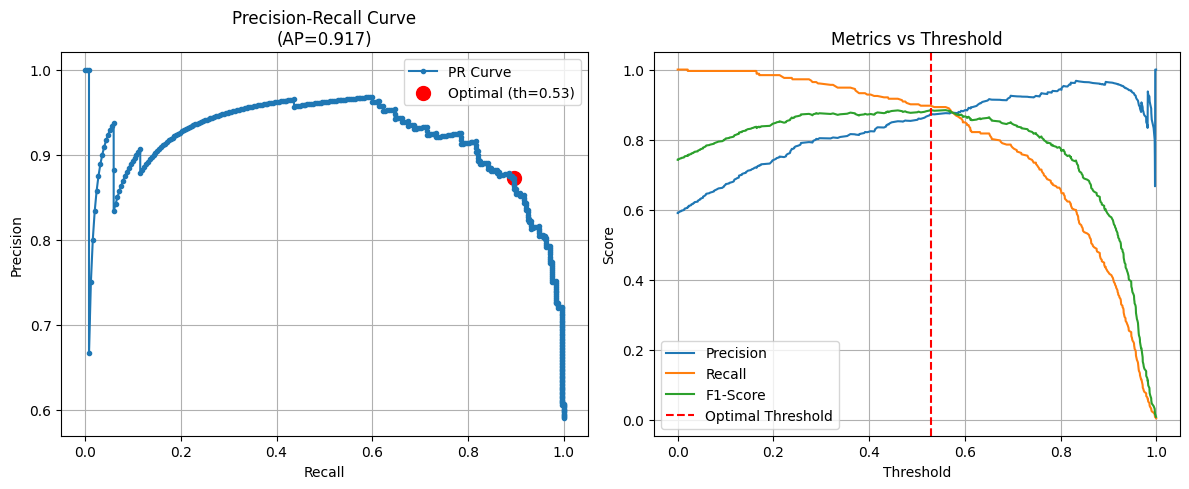

In [24]:
# Precision-Recall Curve with optimal threshold
# For imbalanced data, PR curve is more informative than ROC curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_proba_final)

# Find threshold that maximizes F1 score
# F1 is harmonic mean of precision and recall
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\nOptimal threshold (max F1): {optimal_threshold:.3f}")
print(f"Recall at optimal threshold: {recall_vals[optimal_idx]:.3f}")
print(f"Precision at optimal threshold: {precision_vals[optimal_idx]:.3f}")
print(f"F1 at optimal threshold: {f1_scores[optimal_idx]:.3f}")

# Visualizations
plt.figure(figsize=(12, 5))

# Plot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall_vals, precision_vals, marker='.', label='PR Curve')
plt.scatter(recall_vals[optimal_idx], precision_vals[optimal_idx], 
            color='red', s=100, label=f'Optimal (th={optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\n(AP={average_precision_score(y_val, y_proba_final):.3f})')
plt.legend()
plt.grid(True)

# Plot 2: Threshold vs Metrics
# Shows how metrics change with different thresholds
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-Score')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
print("\n" + "="*80)
print("FINAL MODEL SELECTION")
print("="*80)

# Compile all final results (adjust according to models tested)
final_comparison = pd.DataFrame([
    rf_metrics,
    xgb_metrics,
    lgbm_metrics,
    best_xgb_metrics,  # GridSearch
    optuna_metrics     # Optuna
])

print(final_comparison.to_string(index=False))

# Selection criteria
print("\n" + "="*80)
print("SELECTION CRITERIA")
print("="*80)
print("1. Minimum recall: 0.85 (business requirement)")
print("2. Tie-breaker: PR-AUC (balanced metric for recall/precision)")
print("3. Simplicity: prefer fewer hyperparameters if performance is similar")

# Filter models that meet minimum recall requirement
qualified_models = final_comparison[final_comparison['Recall'] >= 0.85]

# Log model comparison to MLflow
with mlflow.start_run(run_name="Model_Comparison"):
    
    # Log all model metrics for comparison
    for idx, row in final_comparison.iterrows():
        model_name = row['Model'].replace(' ', '_').replace('(', '').replace(')', '')
        mlflow.log_metric(f"{model_name}_recall", row['Recall'])
        mlflow.log_metric(f"{model_name}_precision", row['Precision'])
        mlflow.log_metric(f"{model_name}_f1", row['F1'])
        mlflow.log_metric(f"{model_name}_roc_auc", row['ROC-AUC'])
        mlflow.log_metric(f"{model_name}_pr_auc", row['PR-AUC'])
    
    # Save comparison table
    comparison_path = "model_comparison.csv"
    final_comparison.to_csv(comparison_path, index=False)
    mlflow.log_artifact(comparison_path)
    
    # Log selection criteria
    mlflow.log_param("min_recall_requirement", 0.85)
    mlflow.log_param("tiebreaker_metric", "PR-AUC")
    mlflow.log_metric("n_qualified_models", len(qualified_models))

if len(qualified_models) > 0:
    print(f"\nQualified models (recall >= 0.85): {len(qualified_models)}")
    print(qualified_models[['Model', 'Recall', 'Precision', 'PR-AUC']].to_string(index=False))
    
    # Select best PR-AUC among qualified models
    best_idx = qualified_models['PR-AUC'].idxmax()
    selected_model_name = qualified_models.loc[best_idx, 'Model']
    
    print("\n" + "="*80)
    print(f"SELECTED MODEL: {selected_model_name}")
    print("="*80)
    
    # Get final hyperparameters
    if 'Optuna' in selected_model_name:
        final_model = xgb_optuna
        final_params = best_params_optuna
    elif 'Tuned' in selected_model_name:
        final_model = best_xgb
        final_params = grid_search_xgb.best_params_
    else:
        # Default model
        final_model = xgb_model
        final_params = xgb_model.get_params()
    
    # Log final selection
    with mlflow.start_run(run_name="Final_Model_Selection"):
        mlflow.log_param("selected_model", selected_model_name)
        mlflow.log_params(final_params)
        
        for k, v in qualified_models.loc[best_idx].items():
            if k != 'Model':
                mlflow.log_metric(f"final_{k.lower().replace('-', '_')}", v)
        
        # Log justification as text
        justification = f"""
        Selected Model: {selected_model_name}
        
        Justification:
        - Meets recall requirement >= 0.85: {qualified_models.loc[best_idx, 'Recall']:.3f}
        - Best PR-AUC among qualified models: {qualified_models.loc[best_idx, 'PR-AUC']:.3f}
        - Acceptable precision: {qualified_models.loc[best_idx, 'Precision']:.3f}
        """
        
        justification_path = "model_selection_justification.txt"
        with open(justification_path, 'w') as f:
            f.write(justification)
        mlflow.log_artifact(justification_path)
    
    print("\nFINAL HYPERPARAMETERS:")
    for k, v in final_params.items():
        print(f"  {k}: {v}")
    
    print("\nEXPECTED METRICS (Validation Set):")
    for k, v in qualified_models.loc[best_idx].items():
        if k != 'Model':
            print(f"  {k}: {v:.3f}")
    
    print("\nJUSTIFICATION:")
    print(f"  - Meets recall requirement >= 0.85: {qualified_models.loc[best_idx, 'Recall']:.3f}")
    print(f"  - Best PR-AUC among qualified models: {qualified_models.loc[best_idx, 'PR-AUC']:.3f}")
    print(f"  - Acceptable precision: {qualified_models.loc[best_idx, 'Precision']:.3f}")
    
else:
    print("\nNO MODEL achieved recall >= 0.85")
    
    # Log failure to MLflow
    with mlflow.start_run(run_name="Model_Selection_Failed"):
        mlflow.log_param("selection_status", "FAILED")
        mlflow.log_param("reason", "No model achieved minimum recall requirement")
        mlflow.log_metric("max_recall_achieved", final_comparison['Recall'].max())
    
    print("Recommendations:")
    print("  1. Review feature engineering")
    print("  2. Expand hyperparameter search space")
    print("  3. Consider balancing techniques (SMOTE, undersampling)")
    print("  4. Manually adjust threshold to prioritize recall")


FINAL MODEL SELECTION
           Model   Recall  Precision       F1  ROC-AUC   PR-AUC
    RandomForest 0.817460   0.673203 0.738351 0.678367 0.738965
         XGBoost 0.813492   0.762082 0.786948 0.789320 0.825912
        LightGBM 0.789683   0.742537 0.765385 0.778209 0.818560
 XGBoost (Tuned) 0.825397   0.796935 0.810916 0.844104 0.867952
XGBoost (Optuna) 0.900794   0.856604 0.878143 0.919909 0.916751

SELECTION CRITERIA
1. Minimum recall: 0.85 (business requirement)
2. Tie-breaker: PR-AUC (balanced metric for recall/precision)
3. Simplicity: prefer fewer hyperparameters if performance is similar
🏃 View run Model_Comparison at: http://localhost:5000/#/experiments/2/runs/c7de45e962354dae9402aecdbd872066
🧪 View experiment at: http://localhost:5000/#/experiments/2

Qualified models (recall >= 0.85): 1
           Model   Recall  Precision   PR-AUC
XGBoost (Optuna) 0.900794   0.856604 0.916751

SELECTED MODEL: XGBoost (Optuna)
🏃 View run Final_Model_Selection at: http://localhost:5000/#/e


FINAL EVALUATION - TEST SET


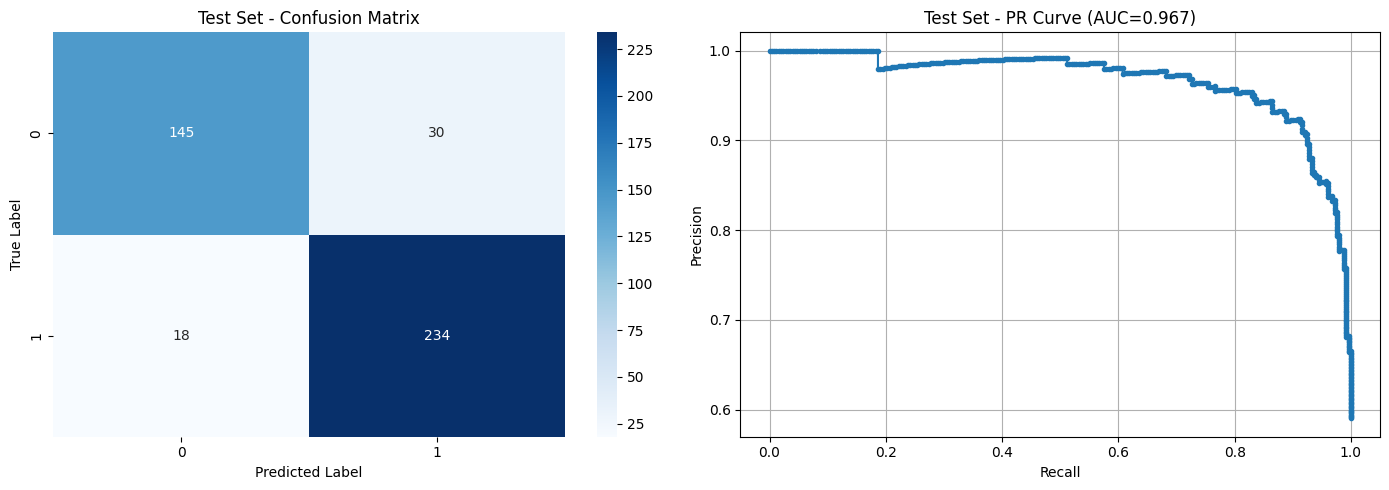

2026/02/05 23:08:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test Set Metrics:
  Recall: 0.929
  Precision: 0.886
  F1: 0.907
  ROC-AUC: 0.956
  PR-AUC: 0.967

Confusion Matrix (Test Set):
[[145  30]
 [ 18 234]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       175
           1       0.89      0.93      0.91       252

    accuracy                           0.89       427
   macro avg       0.89      0.88      0.88       427
weighted avg       0.89      0.89      0.89       427

🏃 View run Final_Test_Evaluation at: http://localhost:5000/#/experiments/2/runs/8543b8b71e1f41b7903a99a839b14e39
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [26]:
print("\n" + "="*80)
print("FINAL EVALUATION - TEST SET")
print("="*80)

# Create final evaluation run in MLflow
with mlflow.start_run(run_name="Final_Test_Evaluation"):
    
    # Log model information
    mlflow.log_param("evaluated_model", selected_model_name)
    mlflow.log_params(final_params)
    
    # Predictions on test set (never seen before)
    # This gives unbiased estimate of model performance
    y_test_pred = final_model.predict(X_test)
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    test_metrics = {
        'Recall': recall_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'F1': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_proba),
        'PR-AUC': average_precision_score(y_test, y_test_proba)
    }
    
    # Log test metrics
    mlflow.log_metric("test_recall", test_metrics['Recall'])
    mlflow.log_metric("test_precision", test_metrics['Precision'])
    mlflow.log_metric("test_f1", test_metrics['F1'])
    mlflow.log_metric("test_roc_auc", test_metrics['ROC-AUC'])
    mlflow.log_metric("test_pr_auc", test_metrics['PR-AUC'])
    
    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm_test.ravel()
    mlflow.log_metric("test_true_negatives", int(tn))
    mlflow.log_metric("test_false_positives", int(fp))
    mlflow.log_metric("test_false_negatives", int(fn))
    mlflow.log_metric("test_true_positives", int(tp))
    
    # Log classification report
    import json
    report = classification_report(y_test, y_test_pred, output_dict=True)
    report_path = "test_classification_report.json"
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    mlflow.log_artifact(report_path)
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Confusion Matrix
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Test Set - Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot 2: Precision-Recall Curve
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
    axes[1].plot(recall_test, precision_test, marker='.')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'Test Set - PR Curve (AUC={test_metrics["PR-AUC"]:.3f})')
    axes[1].grid(True)
    
    plt.tight_layout()
    
    # Save and log figure
    fig_path = "test_evaluation_plots.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()
    
    # Log final model
    if 'XGBoost' in selected_model_name:
        mlflow.xgboost.log_model(final_model, "final_model")
    elif 'LightGBM' in selected_model_name:
        mlflow.lightgbm.log_model(final_model, "final_model")
    else:
        mlflow.sklearn.log_model(final_model, "final_model")
    
    # Save test metrics
    metrics_path = "test_metrics.json"
    with open(metrics_path, 'w') as f:
        json.dump(test_metrics, f, indent=2)
    mlflow.log_artifact(metrics_path)
    
    print("Test Set Metrics:")
    for k, v in test_metrics.items():
        print(f"  {k}: {v:.3f}")
    
    print("\nConfusion Matrix (Test Set):")
    print(cm_test)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

In [27]:
import joblib
from datetime import datetime

# Save final model with MLflow integration
with mlflow.start_run(run_name="Model_Artifacts_Save"):
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model using joblib (for local backup)
    model_filename = f"best_model_{selected_model_name.replace(' ', '_')}_{timestamp}.pkl"
    joblib.dump(final_model, model_filename)
    mlflow.log_artifact(model_filename)
    print(f"\nModel saved locally and to MLflow: {model_filename}")
    
    # Save hyperparameters
    import json
    params_filename = f"best_params_{timestamp}.json"
    with open(params_filename, 'w') as f:
        serializable_params = {k: str(v) if not isinstance(v, (int, float, str, bool, type(None))) else v 
                              for k, v in final_params.items()}
        json.dump(serializable_params, f, indent=2)
    mlflow.log_artifact(params_filename)
    print(f"Hyperparameters saved: {params_filename}")
    
    # Save test metrics
    metrics_filename = f"test_metrics_{timestamp}.json"
    with open(metrics_filename, 'w') as f:
        json.dump(test_metrics, f, indent=2)
    mlflow.log_artifact(metrics_filename)
    print(f"Test metrics saved: {metrics_filename}")
    
    # Log metadata
    mlflow.log_param("model_save_timestamp", timestamp)
    mlflow.log_param("model_filename", model_filename)
    mlflow.log_param("artifacts_saved", "model, params, metrics")
    
    # Create model card
    model_card = f"""
    # Model Card: {selected_model_name}
    
    ## Model Information
    - Model Type: {selected_model_name}
    - Training Date: {timestamp}
    - Random State: {RANDOM_STATE}
    
    ## Dataset
    - Total Samples: {len(df)}
    - Training Samples: {len(X_train)}
    - Validation Samples: {len(X_val)}
    - Test Samples: {len(X_test)}
    - Features: {', '.join(X.columns.tolist())}
    - Target: defasagem (binary: 0/1)
    - Class Imbalance Ratio: {(y == 0).sum() / (y == 1).sum():.2f}
    
    ## Performance Metrics (Test Set)
    - Recall: {test_metrics['Recall']:.3f}
    - Precision: {test_metrics['Precision']:.3f}
    - F1-Score: {test_metrics['F1']:.3f}
    - ROC-AUC: {test_metrics['ROC-AUC']:.3f}
    - PR-AUC: {test_metrics['PR-AUC']:.3f}
    
    ## Hyperparameters
    {json.dumps(serializable_params, indent=2)}
    
    ## Usage
```python
    import joblib
    model = joblib.load('{model_filename}')
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]
```
    
    ## Notes
    - Model optimized for recall (minimum 0.85 requirement)
    - Suitable for imbalanced classification problems
    - Consider recalibration if probability estimates are critical
    """
    
    model_card_path = f"model_card_{timestamp}.md"
    with open(model_card_path, 'w') as f:
        f.write(model_card)
    mlflow.log_artifact(model_card_path)
    print(f"Model card saved: {model_card_path}")
    
    print("\nAll artifacts saved to MLflow!")


Model saved locally and to MLflow: best_model_XGBoost_(Optuna)_20260205_230848.pkl
Hyperparameters saved: best_params_20260205_230848.json
Test metrics saved: test_metrics_20260205_230848.json
Model card saved: model_card_20260205_230848.md

All artifacts saved to MLflow!
🏃 View run Model_Artifacts_Save at: http://localhost:5000/#/experiments/2/runs/4d06a28de71e4166b6745ec97f11ab96
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [28]:
# Compare all runs from the experiment programmatically
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Get experiment by name
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

if experiment:
    # Get all runs from the experiment
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["metrics.recall DESC"]  # Order by recall
    )
    
    print("\n" + "="*80)
    print(f"ALL RUNS IN EXPERIMENT: {EXPERIMENT_NAME}")
    print("="*80)
    print(f"Total runs: {len(runs)}")
    
    # Create comparison dataframe
    comparison_data = []
    for run in runs:
        run_data = {
            'run_id': run.info.run_id,
            'run_name': run.data.tags.get('mlflow.runName', 'N/A'),
            'recall': run.data.metrics.get('recall', None),
            'precision': run.data.metrics.get('precision', None),
            'f1': run.data.metrics.get('f1', None),
            'pr_auc': run.data.metrics.get('pr_auc', None),
            'status': run.info.status
        }
        comparison_data.append(run_data)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Filter only finished runs with metrics
    comparison_df = comparison_df[comparison_df['recall'].notna()]
    
    print("\nTop 10 runs by Recall:")
    print(comparison_df.head(10).to_string(index=False))
    
    # Save comparison
    comparison_path = "mlflow_runs_comparison.csv"
    comparison_df.to_csv(comparison_path, index=False)
    print(f"\nFull comparison saved to: {comparison_path}")
else:
    print(f"Experiment '{EXPERIMENT_NAME}' not found!")


ALL RUNS IN EXPERIMENT: defasagem_prediction
Total runs: 11

Top 10 runs by Recall:
                          run_id                 run_name   recall  precision       f1   pr_auc   status
01a3b2edc4bc4a1badce025f6a3a7250 XGBoost_Tuned_Validation 0.825397   0.796935 0.810916 0.867952 FINISHED
52d25e751920440a84ddd1564c5e7354             RandomForest 0.817460   0.673203 0.738351 0.738965 FINISHED
1387e47260e94b9da08b13f642ff8ed8                  XGBoost 0.813492   0.762082 0.786948 0.825912 FINISHED
6c976393b99b48adb3e7ae1c3601fd16                 LightGBM 0.789683   0.742537 0.765385 0.818560 FINISHED
d3147e88c2be4407baf7a54325c5f0d2          DummyClassifier 0.611111   0.626016 0.618474 0.612074 FINISHED

Full comparison saved to: mlflow_runs_comparison.csv
